 # 化合物寿命延长效应预测分类模型

**任务**: 预测化合物对线虫寿命的具体延长效果 (0, 1)。

**模型**: 基于AttentiveFP处理分子图，CNN处理MACCS指纹，DNN处理Morgan和拓扑指纹，最后融合预测。

**运行环境**: Python 3.9.22 + DeepChem + DGL

#
**重要前提**:

# 1. 数据预处理:
    - 使用`featurizer.py`的脚本处理`train.csv`和`test.csv`，生成图特征 (`adj.npy`, `feature.npy`) 和数值标签 (`label.npy`，直接使用Life_extended列的值)。
    - 使用`fingerprint.py`脚本生成Morgan、拓扑指纹 (`...hash.csv`) 和MACCS指纹 (`...nonhash.csv`)。
    - 所有预处理文件应按`CONFIG`中指定的路径存放。

In [1]:
import sys
import torch

print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)
print("Is CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU name:", torch.cuda.get_device_name(0))

try:
    import deepchem
    print("DeepChem version:", deepchem.__version__)
except ImportError:
    print("DeepChem is not installed.")

# DGL and DGL-LifeSci
try:
    import dgl
    from dgl import batch as dgl_batch
    print("DGL version:", dgl.__version__)
except ImportError:
    print("DGL is not installed.")

try:
    from dgllife.model.gnn import AttentiveFPGNN
    from dgllife.model.readout import AttentiveFPReadout
    import dgllife
    print("DGL-LifeSci (dgllife) version:", dgllife.__version__)
except ImportError:
    print("DGL-LifeSci is not installed.")


Python version: 3.9.22 | packaged by conda-forge | (main, Apr 14 2025, 23:26:18) [MSC v.1929 64 bit (AMD64)]
PyTorch version: 2.1.0+cu118
Is CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
c:\ProgramData\anaconda3\envs\deepchem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\ProgramData\anaconda3\envs\deepchem\lib\site-packages\deepchem\models\torch_models\__init__.p

DeepChem version: 2.8.0
DGL version: 2.2.1+cu118
DGL-LifeSci (dgllife) version: 0.3.2


In [2]:
# CONFIG definition

import torch
import os

PROJECT_BASE_DIR = r"D:\FJTCM\DeepLife\DLProject" # Define this once

CONFIG = {
    "target_name_train": "LifespanReg_train",
    "target_name_test": "LifespanReg_test",
    "train_csv_path": os.path.join(PROJECT_BASE_DIR, "train.csv"),
    "test_csv_path": os.path.join(PROJECT_BASE_DIR, "test.csv"),

    # Path to pre-processed graph features (from run_featurizer_lifespan.py)
    "graph_feature_base_path": os.path.join(PROJECT_BASE_DIR, "processed_graph_features"),
    # Path to pre-processed fingerprints (from run_fingerprint_lifespan_simplified.py)
    "fingerprint_base_path": os.path.join(PROJECT_BASE_DIR, "processed_fingerprints"),

    "results_dir": os.path.join(PROJECT_BASE_DIR, "lifespan_regression_results_notebook"),

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,

    # Featurizer.py related (MUST MATCH run_featurizer_lifespan.py settings)
    "max_atoms_featurizer": 200,
    "atom_feature_dim_featurizer": 75,

    # Fingerprint.py related (MUST MATCH run_fingerprint_lifespan_simplified.py settings)
    "morgan_nbits": 2048,
    "rdkit_fp_nbits": 2048,
    "maccs_nbits": 166,
    # "fingfeaf_dim" will be morgan_nbits + rdkit_fp_nbits
    # "fingfeac_dim" will be maccs_nbits

    # Model architecture
    "enable_graph_gnn": True,
    "enable_fp_hashed_dnn": True,
    "enable_fp_nonhash_cnn": True,
    "gnn_node_input_dim": 78, # From ConvMolFeaturizer used in GraphDataForDGL
    "gnn_edge_input_dim": 11, # From MolGraphConvFeaturizer used in GraphDataForDGL
    "gnn_graph_embed_dim": 128,
    "gnn_num_layers": 2,
    "gnn_num_timesteps": 2,
    "gnn_dropout": 0.5,
    "fp_nonhash_cnn_output_dim": 64,
    "fp_hashed_dnn_layers": [256,128], # Simplified DNN for FPs
    "fp_hashed_dnn_output_dim": 64,   # Reduced output dim for FPs
    "fp_dropout": 0.5,

    # Training
    "n_output_tasks": 1,
    "max_epochs": 100, # Start with fewer for testing
    "batch_size": 32,
    "learning_rate": 0.0001,
    "weight_decay": 1e-4,
    "patience": 15,
    "print_every_n_epochs": 5,
    "main_metric_name": "AUC", # 'RMSE' or 'MAE' for regression (lower is better)
}

# --- Derived CONFIG ---
CONFIG["fingfeaf_dim"] = CONFIG["morgan_nbits"] + CONFIG["rdkit_fp_nbits"]
CONFIG["fingfeac_dim"] = CONFIG["maccs_nbits"]

# --- Create results_dir for Notebook ---
os.makedirs(CONFIG["results_dir"], exist_ok=True)

print(f"Project Base Directory: {PROJECT_BASE_DIR}")
print(f"Graph Features Path: {CONFIG['graph_feature_base_path']}")
print(f"Fingerprints Path: {CONFIG['fingerprint_base_path']}")
print(f"Notebook Results Path: {CONFIG['results_dir']}")
print(f"Using device: {CONFIG['device']}")
print(f"Results will be saved to: {CONFIG['results_dir']}")
print(f"Hashed FP dimension (DNN input): {CONFIG['fingfeaf_dim']}")
print(f"Non-hashed FP dimension (CNN input): {CONFIG['fingfeac_dim']}")

Project Base Directory: D:\FJTCM\DeepLife\DLProject
Graph Features Path: D:\FJTCM\DeepLife\DLProject\processed_graph_features
Fingerprints Path: D:\FJTCM\DeepLife\DLProject\processed_fingerprints
Notebook Results Path: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook
Using device: cuda
Results will be saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook
Hashed FP dimension (DNN input): 4096
Non-hashed FP dimension (CNN input): 166


## 2. 导入所需库

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data, InMemoryDataset, DataLoader as PyGDataLoader
from dgl import batch as dgl_batch
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout

# RDKit and DeepChem (only for on-the-fly featurization if needed, primarily for graph construction in dataset.py style)
from rdkit import Chem
import deepchem as dc # For MolGraphConvFeaturizer if generating edge_features on the fly for DGL

# Metrics from torchmetrics (for regression)
from torchmetrics.functional.regression import pearson_corrcoef

# 设置随机种子
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(CONFIG["seed"])

# Matplotlib/Seaborn 全局样式
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1) # "notebook" context is good for jupyter
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 300


## 3. 定义模型评估指标 (分类)

In [4]:
from abc import ABC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import torch

class BaseMetric(ABC):
    def __init__(self, name):
        super().__init__()
        self.name = name

    def __call__(self, y_true, y_prob):
        # y_prob 是模型的概率输出 (0-1之间)
        if isinstance(y_true, torch.Tensor): y_true = y_true.cpu().numpy()
        if isinstance(y_prob, torch.Tensor): y_prob = y_prob.cpu().numpy()
        y_true = np.squeeze(y_true)
        y_prob = np.squeeze(y_prob)
        return round(self.compute(y_true, y_prob), 4)

    def compute(self, y_true, y_prob):
        raise NotImplementedError

# --- 定义分类指标 ---

class AUC(BaseMetric):
    def __init__(self):
        super().__init__('AUC')
    def compute(self, y_true, y_prob):
        # AUC可以直接使用概率
        return roc_auc_score(y_true, y_prob)

class Accuracy(BaseMetric):
    def __init__(self, threshold=0.5):
        super().__init__('Accuracy')
        self.threshold = threshold
    def compute(self, y_true, y_prob):
        # 将概率根据阈值转换为0/1预测
        y_pred = (y_prob >= self.threshold).astype(int)
        return accuracy_score(y_true, y_pred)

class F1Score(BaseMetric):
    def __init__(self, threshold=0.5):
        super().__init__('F1')
        self.threshold = threshold
    def compute(self, y_true, y_prob):
        y_pred = (y_prob >= self.threshold).astype(int)
        return f1_score(y_true, y_pred)

# --- 构建新的指标字典 ---
# 我们将使用这个新的字典进行评估
metrics_eval_dict_clf = {
    'AUC': AUC(),
    'Accuracy': Accuracy(),
    'F1': F1Score(),
}

# --- 重要：请在您的CONFIG中修改 main_metric_name ---
# 建议将 CONFIG['main_metric_name'] 的值修改为 'AUC'
# AUC是评估二分类模型时更稳健、更常用的核心指标
# EarlyStopping 将会监控验证集AUC，越高越好
MAIN_EVAL_METRIC = metrics_eval_dict_clf[CONFIG['main_metric_name']]

## 4. 定义数据集加载和图数据结构

 - **`GraphDataForDGL`**: 用于创建DGL图对象。
 - **`LifespanInMemoryDataset`**: PyG内存数据集。
 - **`load_and_create_lifespan_dataset`**: 加载所有预处理特征并创建PyG数据集。

In [5]:
from typing import Optional, List

class GraphDataForDGL: # Simplified name for this context
    def __init__(self,
                 node_features_from_featurizer_py: np.ndarray, # From your feature.npy
                 smiles_for_dgl_structure: str, # SMILES to build DGL graph structure
                 use_rdkit_edge_features_for_dgl: bool = True
                ):
        self.node_features_orig = node_features_from_featurizer_py # Store original for potential use
        self.smiles_for_dgl_structure = smiles_for_dgl_structure
        self.use_rdkit_edge_features_for_dgl = use_rdkit_edge_features_for_dgl

        # For DGL graph, we need node features and edge structure.
        # Node features for DGL can be the same as PyG, or re-derived.
        # Let's use DeepChem's ConvMolFeaturizer for DGL node features for consistency with AttentiveFP examples.
        mol = Chem.MolFromSmiles(self.smiles_for_dgl_structure)
        if mol is None:
            raise ValueError(f"Could not parse SMILES for DGL graph: {self.smiles_for_dgl_structure}")

        # Node features for DGL (can be same as PyG or specific for DGL's AttentiveFP)
        # The original GraphEGFR `AttentiveFP_DGL` took `node_feat_size` which matches ConvMolFeaturizer
        dgl_node_featurizer = dc.feat.ConvMolFeaturizer(use_chirality=True)
        dgl_node_feat_obj = dgl_node_featurizer.featurize([mol])[0]
        if dgl_node_feat_obj is None or isinstance(dgl_node_feat_obj, bool):
             raise ValueError(f"DGL Node featurization failed for {self.smiles_for_dgl_structure}")
        self.dgl_node_features = dgl_node_feat_obj.get_atom_features()
        self.num_nodes, self.num_dgl_node_features = self.dgl_node_features.shape

        # Edge index and edge features for DGL (from MolGraphConvFeaturizer)
        dgl_graph_featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True, use_partial_charge=True) # For edge features
        dgl_graph_feat_obj = dgl_graph_featurizer.featurize([mol])[0]
        if dgl_graph_feat_obj is None or isinstance(dgl_graph_feat_obj, bool):
             raise ValueError(f"DGL Graph featurization failed for {self.smiles_for_dgl_structure}")
        self.dgl_edge_index = dgl_graph_feat_obj.edge_index # PyG format (2, num_edges)
        self.dgl_edge_features = dgl_graph_feat_obj.edge_features if self.use_rdkit_edge_features_for_dgl else None

        self.num_dgl_edges = self.dgl_edge_index.shape[1]
        if self.dgl_edge_features is not None:
            self.num_dgl_edge_features = self.dgl_edge_features.shape[1]


    def to_dgl_graph(self, self_loop: bool = True):
        import dgl # Local import
        src = self.dgl_edge_index[0]
        dst = self.dgl_edge_index[1]
        g = dgl.graph((torch.from_numpy(src).long(), torch.from_numpy(dst).long()),
                      num_nodes=self.num_nodes)
        g.ndata['x'] = torch.from_numpy(self.dgl_node_features).float() # Use DGL-specific node features
        if self.dgl_edge_features is not None:
            g.edata['edge_attr'] = torch.from_numpy(self.dgl_edge_features).float()
        if self_loop:
            g = dgl.add_self_loop(g)
        return g

class LifespanInMemoryDataset(InMemoryDataset):
    def __init__(self, root_temp_dir, data_list=None, transform=None, pre_transform=None):
        self.data_list_to_process = data_list # Store a temp copy
        super(LifespanInMemoryDataset, self).__init__(root_temp_dir, transform, pre_transform)
        # Data is loaded from processed_paths by the parent class
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['lifespan_pyg_data.pt'] # Unique name for this dataset

    def process(self):
        # This method is called if processed_file_names doesn't exist.
        # It collates self.data_list_to_process and saves it.
        if self.data_list_to_process is None:
             # This typically means it's trying to load, but process() was called.
             # Or, it's the first time and data_list wasn't passed correctly.
             # For robustness, initialize to empty list if it's truly None.
             print("Warning: data_list_to_process is None in LifespanInMemoryDataset.process().")
             self.data_list_to_process = []

        data, slices = self.collate(self.data_list_to_process)
        torch.save((data, slices), self.processed_paths[0])
        print(f"Processed PyG data saved to {self.processed_paths[0]}")


def load_and_create_lifespan_dataset(
    smiles_list: List[str],
    target_name: str, # e.g., "LifespanReg_train"
    config_dict: dict,
    is_train_or_val: bool = True # To load labels or not
):
    print(f"--- Preparing PyG Dataset for: {target_name} ---")
    # graph_feat_path and fingerprint_path are now correctly constructed using config_dict
    graph_feat_npdata_path = os.path.join(config_dict["graph_feature_base_path"], "npdata", target_name)
    fingerprint_files_path = os.path.join(config_dict["fingerprint_base_path"], "fingerprint", target_name) # Path to the FOLDER

    # Load pre-processed graph features
    adj_all = np.load(os.path.join(graph_feat_npdata_path, "adj.npy"), allow_pickle=True)
    atom_features_all = np.load(os.path.join(graph_feat_npdata_path, "feature.npy"), allow_pickle=True)

    # Load pre-processed fingerprints (filenames are now just hash.csv and nonhash.csv inside the folder)
    fpf_df = pd.read_csv(os.path.join(fingerprint_files_path, "hash.csv"))
    fpc_df = pd.read_csv(os.path.join(fingerprint_files_path, "nonhash.csv"))
    fpf_np = fpf_df.to_numpy(dtype=np.float32)
    fpc_np = fpc_df.to_numpy(dtype=np.float32)

    labels_np = None
    if is_train_or_val:
        label_file = os.path.join(graph_feat_npdata_path, "label.npy") # graph_feat_npdata_path
        if not os.path.exists(label_file):
            raise FileNotFoundError(f"Label file not found: {label_file}. Ensure it was generated by featurizer script.")
        labels_np = np.load(label_file, allow_pickle=True).astype(np.float32)
        if len(labels_np) != len(smiles_list):
             raise ValueError(f"Label count ({len(labels_np)}) for {target_name} does not match SMILES count ({len(smiles_list)}). Check pre-processing alignment.")


    # Length check for all loaded features against SMILES list
    num_smiles = len(smiles_list)
    if not (len(adj_all) == num_smiles and \
            len(atom_features_all) == num_smiles and \
            len(fpf_np) == num_smiles and \
            len(fpc_np) == num_smiles):
        raise ValueError(f"Feature length mismatch for {target_name}. "
                         f"SMILES: {num_smiles}, Adj: {len(adj_all)}, AtomFeat: {len(atom_features_all)}, "
                         f"FP_Hash: {len(fpf_np)}, FP_NonHash: {len(fpc_np)}. "
                         "Ensure pre-processing output is consistent for all molecules in the list.")


    pyg_data_list = []
    skipped_smiles_indices = []

    for i, smiles_str in enumerate(tqdm(smiles_list, desc=f"Creating PyG objects for {target_name}")):
        try:
            # PyG node features are taken directly from the pre-processed feature.npy
            # This assumes feature.npy contains unpadded or correctly shaped node features
            # OR, if feature.npy is padded, the model needs to handle it or unpad.
            # The original featurizer.py pads to (max_dim, 75).
            # For PyG, we typically want unpadded features per graph.
            # Let's assume atom_features_all[i] is the (num_atoms_for_mol_i, 75) array.
            # If your `feature.npy` saves a list of these unpadded arrays, that's ideal.
            # If it saves one giant stacked padded array, you need to extract the unpadded part.
            # For simplicity, assume `atom_features_all[i]` is the correct unpadded (N_atoms, 75) for molecule i.
            # This requires your `feature.npy` (from `get_feature`) to save a list of arrays if `np.stack` was used on unpadded.
            # If `True_array_feature = np.stack(True_feature.values)` and True_feature contains padded arrays,
            # then `atom_features_all` is already a 3D tensor of padded features.
            # This is a CRITICAL point of how your featurizer.py saves feature.npy.

            # Let's assume `feature.npy` as loaded by `atom_features_all` is a list of per-molecule
            # unpadded feature matrices, or a 3D tensor from which we can extract.
            # For this example, we will re-featurize for PyG `x` for simplicity of unpadded features.
            # The pre-loaded `atom_features_all` might be used if its format is clear.
            mol_for_pyg_x = Chem.MolFromSmiles(smiles_str)
            if mol_for_pyg_x is None:
                print(f"Skipping {smiles_str} (RDKit parsing failed for PyG node features).")
                skipped_smiles_indices.append(i)
                continue
            
            pyg_node_featurizer = dc.feat.ConvMolFeaturizer(use_chirality=True) # For PyG 'x'
            pyg_node_feat_obj = pyg_node_featurizer.featurize([mol_for_pyg_x])[0]
            if pyg_node_feat_obj is None or isinstance(pyg_node_feat_obj, bool):
                print(f"Skipping {smiles_str} (PyG node featurization failed).")
                skipped_smiles_indices.append(i)
                continue
            pyg_x = torch.from_numpy(pyg_node_feat_obj.get_atom_features()).float()

            # For edge_index and edge_attr, we re-featurize with MolGraphConvFeaturizer
            # This is consistent with how dataset.py often works for PyG
            pyg_graph_featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
            pyg_graph_obj = pyg_graph_featurizer.featurize([mol_for_pyg_x])[0]
            if pyg_graph_obj is None or isinstance(pyg_graph_obj, bool):
                print(f"Skipping {smiles_str} (PyG graph structure featurization failed).")
                skipped_smiles_indices.append(i)
                continue
            pyg_edge_index = torch.from_numpy(pyg_graph_obj.edge_index).long()
            pyg_edge_attr = torch.from_numpy(pyg_graph_obj.edge_features).float()


            # Create DGL graph object using GraphDataForDGL
            # It uses its own featurizers for consistency with DGL AttentiveFP examples
            dgl_graph_maker = GraphDataForDGL(
                node_features_from_featurizer_py = atom_features_all[i], # Pass the pre-loaded one
                smiles_for_dgl_structure = smiles_str,
                use_rdkit_edge_features_for_dgl = (CONFIG["gnn_edge_input_dim"] > 0) # If model expects edge features
            )
            dgl_graph = dgl_graph_maker.to_dgl_graph(self_loop=True)

            current_fpf = fpf_np[i] # This is a 1D array for the i-th molecule
            current_fpc = fpc_np[i] # This is a 1D array for the i-th molecule

            fpf_tensor = torch.from_numpy(current_fpf).float().unsqueeze(0) # Shape: [1, fingfeaf_dim]
            fpc_tensor = torch.from_numpy(current_fpc).float().unsqueeze(0) # Shape: [1, fingfeac_dim]

            current_label_val = labels_np[i] if is_train_or_val and labels_np is not None else np.nan # Get scalar label


            data = Data(
                x=pyg_x,                      # Unpadded node features for PyG
                edge_index=pyg_edge_index,    # Unpadded edge index for PyG
                edge_attr=pyg_edge_attr,      # Unpadded edge attributes for PyG
                 y=torch.tensor([[current_label_val]], dtype=torch.float) if is_train_or_val and labels_np is not None else torch.empty((0,1), dtype=torch.float),  
                 # Ensure y is [1,1] for each sample, handle NaN for current_label_val
                adj_loaded=torch.from_numpy(adj_all[i]).float(), # Padded adj from featurizer.py
                fpf=torch.from_numpy(fpf_np[i]).float(),
                fpc=torch.from_numpy(fpc_np[i]).float(),
                dgl_graph=dgl_graph,          # DGL graph object
                smiles=smiles_str             # Store SMILES for later reference
            )
            pyg_data_list.append(data)

        except Exception as e:
            print(f"Error processing SMILES {smiles_str} (index {i}): {e}. Skipping.")
            skipped_smiles_indices.append(i)
            continue

    if not pyg_data_list:
        raise ValueError(f"No valid PyG Data objects could be created for {target_name}.")

    # Create a temporary unique directory for this specific dataset processing run
    # to avoid conflicts if this function is called multiple times.
    dataset_temp_root = os.path.join(config_dict["results_dir"], ".tmp_pyg_cache", target_name)
    if os.path.exists(dataset_temp_root): # Clean up old temp data for this target
        shutil.rmtree(dataset_temp_root)
    os.makedirs(dataset_temp_root, exist_ok=True)

    print(f"Creating LifespanInMemoryDataset for {target_name} with {len(pyg_data_list)} graphs at {dataset_temp_root}...")
    dataset = LifespanInMemoryDataset(root_temp_dir=dataset_temp_root, data_list=pyg_data_list)
    
    # It's good practice to clean up the temp dir if the dataset is truly "in-memory"
    # However, LifespanInMemoryDataset loads from this path on init if .pt exists.
    # If you want it purely in memory after first creation, you'd delete it AFTER
    # the dataset object is fully initialized and data loaded into its .data attribute.
    # For now, let's leave it, as subsequent runs for same target might try to load from it.
    # Or, manage deletion carefully. A robust way is to use a truly temporary unique dir.

    print(f"Successfully created PyG dataset for {target_name} with {len(dataset)} graphs.")
    
    # Return the dataset and a list of SMILES that were successfully processed and included
    final_smiles_in_dataset = [d.smiles for d in dataset]
    return dataset, final_smiles_in_dataset

## 5. 定义模型架构
 - `AttentiveFPModule`: DGL AttentiveFP.
 - `LifespanPredictorModel`: Main model.
 - `ModelTrainingWrapper`: Handles training, prediction, loss.


In [6]:
# --- AttentiveFP Module (using DGL-LifeSci) ---
class AttentiveFPModule(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, num_layers, num_timesteps, graph_feat_size, dropout):
        super().__init__()
        self.gnn = AttentiveFPGNN(
            node_feat_size=node_feat_size,
            edge_feat_size=edge_feat_size,
            num_layers=num_layers,
            graph_feat_size=graph_feat_size,
            dropout=dropout
        )
        self.readout = AttentiveFPReadout(
            feat_size=graph_feat_size,
            num_timesteps=num_timesteps,
            dropout=dropout
        )
    def forward(self, dgl_g, node_feats, edge_feats): # dgl_g is a batched DGL graph
        node_feats = self.gnn(dgl_g, node_feats, edge_feats)
        graph_feats = self.readout(dgl_g, node_feats)
        return graph_feats

# --- Main Predictor Model ---
class LifespanPredictorModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.enable_gnn = config['enable_graph_gnn']
        self.enable_fp_hash = config['enable_fp_hashed_dnn']
        self.enable_fp_nonhash = config['enable_fp_nonhash_cnn']

        # 1. AttentiveFP GNN for graph features
        if self.enable_gnn:
            self.attentive_fp_module = AttentiveFPModule(
                node_feat_size=config['gnn_node_input_dim'],
                edge_feat_size=config['gnn_edge_input_dim'],
                num_layers=config['gnn_num_layers'],
                num_timesteps=config['gnn_num_timesteps'],
                graph_feat_size=config['gnn_graph_embed_dim'],
                dropout=config['gnn_dropout']
            )

        # 2. CNN for non-hashed fingerprints (e.g., MACCS)
        if self.enable_fp_nonhash:
            self.cnn_nonhash_fp = nn.Sequential(
                # Input: (batch, fingfeac_dim, 1) - MACCS dim as channels, length 1
                nn.Conv1d(config['fingfeac_dim'], 128, kernel_size=1), # kernel_size=1 for dense-like
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(config['fp_dropout']),
                nn.Conv1d(128, config['fp_nonhash_cnn_output_dim'], kernel_size=1),
                nn.ReLU(),
                nn.BatchNorm1d(config['fp_nonhash_cnn_output_dim'])
                # Output: (batch, fp_nonhash_cnn_output_dim, 1) -> squeeze later
            )

        # 3. DNN for hashed fingerprints (e.g., Morgan + Topological)
        if self.enable_fp_hash:
            dnn_layers = []
            input_dim = config['fingfeaf_dim']
            for hidden_dim in config['fp_hashed_dnn_layers']:
                dnn_layers.append(nn.Linear(input_dim, hidden_dim))
                dnn_layers.append(nn.BatchNorm1d(hidden_dim))
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Dropout(config['fp_dropout']))
                input_dim = hidden_dim
            dnn_layers.append(nn.Linear(input_dim, config['fp_hashed_dnn_output_dim']))
            self.dnn_hash_fp = nn.Sequential(*dnn_layers)

        # Calculate combined feature dimension for the final prediction layer
        combined_feat_dim = 0
        if self.enable_gnn:
            combined_feat_dim += config['gnn_graph_embed_dim']
        if self.enable_fp_nonhash:
            combined_feat_dim += config['fp_nonhash_cnn_output_dim']
        if self.enable_fp_hash:
            combined_feat_dim += config['fp_hashed_dnn_output_dim']

        if combined_feat_dim == 0:
            raise ValueError("No feature modules enabled. Model cannot learn.")

        # Final prediction layer (regression)
        self.fc_out = nn.Sequential(
            nn.Linear(combined_feat_dim, combined_feat_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2), # Add some dropout before final output
            nn.Linear(combined_feat_dim // 2, config['n_output_tasks']) # n_output_tasks = 1 for regression
        )

    def forward(self, pyg_batch_data):
        # pyg_batch_data is a PyTorch Geometric Batch object

        # --- Get batch size ---
        # This is the most reliable way to get batch size from PyG Batch object
        current_batch_size = pyg_batch_data.num_graphs

         # --- Process Hashed Fingerprints (fpf) ---
        fp_hashed = pyg_batch_data.fpf.to(self.config['device'])
        # Expected shape: [batch_size, fingfeaf_dim]
        # If it's 1D [batch_size * fingfeaf_dim], reshape it.
        if self.enable_fp_hash:
            if fp_hashed.ndim == 1:
                expected_elements = current_batch_size * self.config['fingfeaf_dim']
                if fp_hashed.shape[0] == expected_elements:
                    print(f"DEBUG: Reshaping fp_hashed from {fp_hashed.shape} to ({current_batch_size}, {self.config['fingfeaf_dim']})")
                    fp_hashed = fp_hashed.reshape(current_batch_size, self.config['fingfeaf_dim'])
                else: # This would be an unexpected error
                    raise ValueError(f"Batched fpf has unexpected 1D shape {fp_hashed.shape}. "
                                     f"Expected {expected_elements} elements for batch size {current_batch_size}.")
            elif fp_hashed.ndim == 2 and fp_hashed.shape[0] != current_batch_size:
                 raise ValueError(f"Batched fpf has shape {fp_hashed.shape}, but batch size is {current_batch_size}.")
            # print(f"DEBUG: fp_hashed shape: {fp_hashed.shape}")


        # --- Process Non-Hashed Fingerprints (fpc) ---
        fp_non_hashed = pyg_batch_data.fpc.to(self.config['device'])
        # Expected shape: [batch_size, fingfeac_dim]
        # If it's 1D [batch_size * fingfeac_dim], reshape it.
        if self.enable_fp_nonhash:
            if fp_non_hashed.ndim == 1:
                expected_elements = current_batch_size * self.config['fingfeac_dim']
                if fp_non_hashed.shape[0] == expected_elements:
                    print(f"DEBUG: Reshaping fp_non_hashed from {fp_non_hashed.shape} to ({current_batch_size}, {self.config['fingfeac_dim']})")
                    fp_non_hashed = fp_non_hashed.reshape(current_batch_size, self.config['fingfeac_dim'])
                else: # This would be an unexpected error
                    raise ValueError(f"Batched fpc has unexpected 1D shape {fp_non_hashed.shape}. "
                                     f"Expected {expected_elements} elements for batch size {current_batch_size}.")
            elif fp_non_hashed.ndim == 2 and fp_non_hashed.shape[0] != current_batch_size:
                 raise ValueError(f"Batched fpc has shape {fp_non_hashed.shape}, but batch size is {current_batch_size}.")
            # print(f"DEBUG: fp_non_hashed shape: {fp_non_hashed.shape}")

        # DGL graph processing (needs careful batch handling)
        # 1. Get individual DGL graphs from the PyG batch
        # 2. Batch them using dgl.batch
        # 3. Extract node/edge features that correspond to this DGL batch structure
        dgl_graphs_list = [d.dgl_graph for d in pyg_batch_data.to_data_list()]
        batched_dgl_graph = dgl_batch(dgl_graphs_list).to(self.config['device'])
        
        # Node and edge features for the DGL batched graph
        # These come from the .ndata and .edata of the batched DGL graph itself
        dgl_node_features = batched_dgl_graph.ndata['x'].to(self.config['device'])
        dgl_edge_features = batched_dgl_graph.edata.get('edge_attr', None)
        if dgl_edge_features is not None:
            dgl_edge_features = dgl_edge_features.to(self.config['device'])


        processed_features_list = []

        # 1. GNN features
        if self.enable_gnn:
            # Ensure dgl_edge_features is passed only if model expects it and features exist
            if self.config['gnn_edge_input_dim'] > 0 and dgl_edge_features is not None:
                 graph_embed = self.attentive_fp_module(batched_dgl_graph, dgl_node_features, dgl_edge_features)
            elif self.config['gnn_edge_input_dim'] == 0 : # Model doesn't use edge features
                 graph_embed = self.attentive_fp_module(batched_dgl_graph, dgl_node_features, None)
            else: # Model expects edge features but they are None in data
                 raise ValueError("GNN model expects edge features, but they are None in the DGL graph batch.")
            processed_features_list.append(graph_embed)

        # 2. CNN for non-hashed fingerprints
        if self.enable_fp_nonhash:
            # CNN expects (batch, channels, length). Here, channels=fingfeac_dim, length=1
            fp_non_hashed_cnn_in = fp_non_hashed.unsqueeze(2) # (batch, fingfeac_dim, 1)
            cnn_out = self.cnn_nonhash_fp(fp_non_hashed_cnn_in) # (batch, cnn_output_dim, 1)
            cnn_out_squeezed = cnn_out.squeeze(2) # (batch, cnn_output_dim)
            processed_features_list.append(cnn_out_squeezed)

        # 3. DNN for hashed fingerprints
        if self.enable_fp_hash:
            dnn_out = self.dnn_hash_fp(fp_hashed) # (batch, dnn_output_dim)
            processed_features_list.append(dnn_out)

        if not processed_features_list:
            raise ValueError("Forward pass: No features were processed.")

        # Concatenate all features
        combined_features = torch.cat(processed_features_list, dim=1)

        # Final prediction
        output = self.fc_out(combined_features) # Raw output (logits for classification, direct value for regression)
        return output


# --- Model Training Wrapper (Simplified) ---
class ModelTrainingWrapper:
    def __init__(self, model, config):
        self.model = model.to(config['device'])
        self.config = config
        self.optimizer = torch.optim.AdamW( # AdamW is often a good default
            self.model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
        # For classification, using Binary Cross-Entropy Loss
        self.loss_fn = nn.MSELoss(reduction='mean')

    def train_one_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        for batch_data in train_loader:
            batch_data = batch_data.to(self.config['device'])
            # Labels are expected to be [batch_size, 1] for regression
            labels = batch_data.y.to(self.config['device']).float() # Ensure float

            # --- ADD/MODIFY THIS CHECK AND RESHAPE FOR LABELS ---
            if labels.ndim == 1: # If labels are [batch_size]
                labels = labels.unsqueeze(1) # Reshape to [batch_size, 1]
            # Ensure labels shape matches predictions shape if predictions are [batch_size, 1]
            # This check is good practice generally.

            self.optimizer.zero_grad()
            predictions_logits = self.model(batch_data) # Predictions will be [batch_size, 1] 模型输出的是原始分数值(logits)
            # BCEWithLogitsLoss 直接使用logits和0/1标签，非常方便
            loss = self.loss_fn(predictions_logits, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def evaluate(self, data_loader, has_labels=True): # Add has_labels parameter
        self.model.eval()
        all_logits_list = [] # Use list to append, then concat
        all_true_labels_list = [] # Use list for labels too
        total_loss = 0
        num_batches_with_loss = 0

        with torch.no_grad():
            for batch_data in data_loader:
                batch_data = batch_data.to(self.config['device'])
                predictions_logits = self.model(batch_data)
                all_logits_list.append(predictions_logits.cpu())

                if has_labels and batch_data.y.numel() > 0:
                    labels = batch_data.y.to(self.config['device']).float()
                    if labels.ndim == 1:
                        labels = labels.unsqueeze(1)
                    
                    loss = self.loss_fn(predictions_logits, labels)
                    total_loss += loss.item()
                    num_batches_with_loss += 1
                    all_true_labels_list.append(labels.cpu())


        # --- MODIFICATION : 评估逻辑更新 ---
        avg_loss = total_loss / num_batches_with_loss if num_batches_with_loss > 0 else np.nan
        
        # 将所有批次的logits拼接起来
        all_logits_cat = torch.cat(all_logits_list, dim=0)
        # 通过Sigmoid函数将logits转换为概率 (0-1之间)
        all_probabilities_cat = torch.sigmoid(all_logits_cat).numpy()

        scores = {"loss": avg_loss}

        if has_labels and all_true_labels_list:
            all_true_labels_cat = torch.cat(all_true_labels_list, dim=0).numpy()
            # 使用新的分类指标字典进行评估
            for metric_name, metric_fn_obj in metrics_eval_dict_clf.items():
                try:
                    # 将真实标签和预测概率传给指标函数
                    scores[metric_name] = metric_fn_obj(all_true_labels_cat, all_probabilities_cat)
                except Exception as e:
                    scores[metric_name] = np.nan
            return scores, all_true_labels_cat, all_probabilities_cat # 返回概率
        else:
            # 如果没有标签，也用NaN填充分类指标
            for metric_name in metrics_eval_dict_clf.keys():
                scores.setdefault(metric_name, np.nan)
            return scores, np.array([]), all_probabilities_cat # 返回概率

## 6. 定义工具函数 (EarlyStopping)

In [7]:
class EarlyStoppingNotebook:
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print, mode='min'):
        """
        Args:
            patience (int): How long to wait after last time validation metric improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation metric improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
            path (str): Path for the checkpoint to be saved to.
                        Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                                   Default: print            
            mode (str): One of 'min' or 'max'. In 'min' mode, training will stop when the quantity 
                        monitored has stopped decreasing; in 'max' mode it will stop when the 
                        quantity monitored has stopped increasing.
                        Default: 'min'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path
        self.trace_func = trace_func
        self.mode = mode
        
        # --- MODIFICATION 1: 根据模式调整 delta 和 best_score 的初始值 ---
        if self.mode == 'min':
            self.delta = delta
            self.val_metric_at_best = np.Inf # 用于打印比较
        else: # mode == 'max'
            self.delta = -delta # 对于max模式，delta应该是负的，因为 score > best + (-delta)
            self.val_metric_at_best = -np.Inf # 用于打印比较

    def __call__(self, current_val_metric, model):
        score = current_val_metric

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(current_val_metric, model)
        
        # --- MODIFICATION 2: 统一并简化核心判断逻辑 ---
        # 使用一个统一的表达式来判断性能是否没有提升
        elif (self.mode == 'min' and score > self.best_score + self.delta) or \
             (self.mode == 'max' and score < self.best_score - self.delta):
            
            self.counter += 1
            if self.verbose:
                # 打印信息现在总是正确的
                self.trace_func(f'EarlyStopping counter: {self.counter}/{self.patience} (Best: {self.best_score:.4f}, Current: {score:.4f})')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # 性能提升
            self.best_score = score
            self.save_checkpoint(current_val_metric, model)
            self.counter = 0

    def save_checkpoint(self, current_val_metric, model):
        # --- MODIFICATION 3: 统一并简化打印逻辑 ---
        if self.verbose:
            self.trace_func(f'Validation metric improved ({self.val_metric_at_best:.4f} --> {current_val_metric:.4f}). Saving model to {self.path} ...')
        torch.save(model.state_dict(), self.path)
        # 记录下当前最好的metric值，用于下一次的打印对比
        self.val_metric_at_best = current_val_metric

## 7. 加载训练和测试数据 (适配为分类任务)

In [9]:
# --- Load train.csv to get SMILES and create numerical labels ---
print("Loading train.csv for SMILES and actual class labels (0/1)...")
train_df_raw_full = pd.read_csv(CONFIG["train_csv_path"])
# 确保标签是0/1的整数类型，这对于分层采样和分类损失函数很重要
train_labels_categorical = train_df_raw_full['Life_extended'].to_numpy(dtype=np.int64) 
train_smiles_full = train_df_raw_full['SMILES'].tolist() # Get SMILES after ensuring labels are processed

# --- 保存标签 ---
# 虽然是分类标签，但保存为npy文件的方式是一样的
train_label_np_path = os.path.join(
    CONFIG["graph_feature_base_path"], "npdata", CONFIG["target_name_train"], "label.npy"
)
os.makedirs(os.path.dirname(train_label_np_path), exist_ok=True)
np.save(train_label_np_path, train_labels_categorical)
print(f"Categorical labels for training saved to: {train_label_np_path}")

# --- Create full training dataset using PyG ---
# This function now expects paths to pre-generated features AND the SMILES list
# It will also load the numerical labels from the label_np_path_reg we just saved.
full_train_pyg_dataset, processed_train_smiles = load_and_create_lifespan_dataset(
    smiles_list=train_smiles_full,
    target_name=CONFIG["target_name_train"],
    config_dict=CONFIG,
    is_train_or_val=True # True to load labels
)

# --- Align labels with the SMILES that were successfully processed into the PyG dataset ---
# Find indices of processed_train_smiles in the original train_smiles_full
original_indices_in_pyg_dataset = [train_smiles_full.index(s) for s in processed_train_smiles if s in train_smiles_full]
aligned_train_labels = train_labels_categorical[original_indices_in_pyg_dataset]
print(f"Number of original train SMILES: {len(train_smiles_full)}")
print(f"Number of SMILES in PyG train dataset: {len(full_train_pyg_dataset)}")
print(f"Number of aligned labels: {len(aligned_train_labels)}")


# --- Split PyG training data into train and validation sets 使用分层采样(Stratified Sampling)来划分训练集和验证集 ---
num_pyg_samples = len(full_train_pyg_dataset)
pyg_indices = list(range(num_pyg_samples))

print(f"\nSplitting data with stratification to preserve class distribution...")
# 我们在 aligned_train_labels 上进行分层，以确保划分后的数据集中0和1的比例不变
train_idx, val_idx = train_test_split(
    pyg_indices,
    test_size=0.3, # 验证集大小
    random_state=CONFIG["seed"],
    stratify=aligned_train_labels  # <-- 关键的分层参数
)

train_pyg_subset = full_train_pyg_dataset.index_select(train_idx)
val_pyg_subset = full_train_pyg_dataset.index_select(val_idx)


print(f"Training subset size: {len(train_pyg_subset)}")
print(f"Validation subset size: {len(val_pyg_subset)}")

# 检查一下划分后两个集合中的类别分布是否均衡 (可选但推荐)
train_labels_subset = aligned_train_labels[train_idx]
val_labels_subset = aligned_train_labels[val_idx]
print(f"Train set class distribution: {np.bincount(train_labels_subset)} (counts of 0s and 1s)")
print(f"Validation set class distribution: {np.bincount(val_labels_subset)} (counts of 0s and 1s)")


# --- 创建DataLoaders  ---
train_loader = PyGDataLoader(train_pyg_subset, batch_size=CONFIG["batch_size"], shuffle=True, drop_last=True)
val_loader = PyGDataLoader(val_pyg_subset, batch_size=CONFIG["batch_size"], shuffle=False)


# --- 加载和准备 test.csv 数据 ---
# 测试集通常没有标签，所以它的加载过程不受影响
print("\nLoading and preparing test.csv data for final prediction...")
test_df_raw_full = pd.read_csv(CONFIG["test_csv_path"])
test_smiles_full = test_df_raw_full['SMILES'].tolist()

test_pyg_dataset, processed_test_smiles_final_test_set = load_and_create_lifespan_dataset(
    smiles_list=test_smiles_full,
    target_name=CONFIG["target_name_test"],
    config_dict=CONFIG,
    is_train_or_val=False # is_train_or_val=False 意味着不加载标签，这对于测试集是正确的
)
test_loader = PyGDataLoader(test_pyg_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

print(f"Test PyG dataset size: {len(test_pyg_dataset)}")
print(f"Number of SMILES in processed test dataset: {len(processed_test_smiles_final_test_set)}")

Loading train.csv for SMILES and actual class labels (0/1)...
Categorical labels for training saved to: D:\FJTCM\DeepLife\DLProject\processed_graph_features\npdata\LifespanReg_train\label.npy
--- Preparing PyG Dataset for: LifespanReg_train ---


Creating PyG objects for LifespanReg_train:  13%|█▎        | 211/1679 [00:03<00:23, 63.31it/s]Failed to featurize datapoint 0, [Hf]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Creating PyG objects for LifespanReg_train:  14%|█▎        | 227/1679 [00:03<00:21, 66.60it/s]

Error processing SMILES [Hf] (index 215): 'numpy.ndarray' object has no attribute 'edge_index'. Skipping.


Creating PyG objects for LifespanReg_train: 100%|██████████| 1679/1679 [00:23<00:00, 71.05it/s] 
Processing...


Creating LifespanInMemoryDataset for LifespanReg_train with 1678 graphs at D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\.tmp_pyg_cache\LifespanReg_train...
Processed PyG data saved to D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\.tmp_pyg_cache\LifespanReg_train\processed\lifespan_pyg_data.pt


Done!


Successfully created PyG dataset for LifespanReg_train with 1678 graphs.


c:\ProgramData\anaconda3\envs\deepchem\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Number of original train SMILES: 1679
Number of SMILES in PyG train dataset: 1678
Number of aligned labels: 1678

Splitting data with stratification to preserve class distribution...
Training subset size: 1174
Validation subset size: 504
Train set class distribution: [844 330] (counts of 0s and 1s)
Validation set class distribution: [362 142] (counts of 0s and 1s)

Loading and preparing test.csv data for final prediction...
--- Preparing PyG Dataset for: LifespanReg_test ---


Creating PyG objects for LifespanReg_test: 100%|██████████| 21/21 [00:00<00:00, 55.87it/s]

Creating LifespanInMemoryDataset for LifespanReg_test with 21 graphs at D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\.tmp_pyg_cache\LifespanReg_test...
Processed PyG data saved to D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\.tmp_pyg_cache\LifespanReg_test\processed\lifespan_pyg_data.pt
Successfully created PyG dataset for LifespanReg_test with 21 graphs.
Test PyG dataset size: 21
Number of SMILES in processed test dataset: 21



Processing...
Done!
c:\ProgramData\anaconda3\envs\deepchem\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## 8. 模型训练与验证(适配为分类任务)

In [10]:
# --- Initialize Model, Optimizer, EarlyStopping ---
# --- 初始化模型、优化器和新的分类评估指标 ---
lifespan_model = LifespanPredictorModel(CONFIG).to(CONFIG["device"])
training_wrapper = ModelTrainingWrapper(lifespan_model, CONFIG)

# --- 核心修改 1: 更新检查点路径和EarlyStopping的配置 ---
checkpoint_path_clf = os.path.join(CONFIG["results_dir"], "best_classification_model.pt")

# 早停现在将监控一个分类指标 (比如AUC)，并且模式是'max' (越高越好)
# 确保你的CONFIG['main_metric_name'] 已经被设置为 'AUC'
early_stopper_clf = EarlyStoppingNotebook(
    patience=CONFIG["patience"],
    verbose=True,
    path=checkpoint_path_clf,
    mode='max'  # <-- 关键修改：监控的指标是越大越好
)


# --- 核心修改 2: 更新训练历史记录的字典结构 ---
training_history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [], # 这将是BCEWithLogitsLoss
}
# 使用新的分类指标字典来初始化历史记录
for metric_name in metrics_eval_dict_clf.keys():
    training_history[f"val_{metric_name}"] = []


print("\n--- Starting Model Training (Classification) ---") # <-- 更新标题
for epoch in range(CONFIG["max_epochs"]):
    # 训练一个周期
    avg_epoch_train_loss = training_wrapper.train_one_epoch(train_loader)
    
    # 在验证集上评估
    # 注意：这里的评估函数现在会返回分类指标
    val_scores_dict, _, _ = training_wrapper.evaluate(val_loader, has_labels=True)

    # --- 核心修改 3: 更新历史记录的填充逻辑 ---
    training_history["epoch"].append(epoch + 1)
    training_history["train_loss"].append(avg_epoch_train_loss)
    training_history["val_loss"].append(val_scores_dict["loss"]) # 这是 BCE Loss
    # 使用新的分类指标字典来填充历史记录
    for metric_name in metrics_eval_dict_clf.keys():
        training_history[f"val_{metric_name}"].append(val_scores_dict[metric_name])

    # --- 核心修改 4: 更新打印日志的逻辑 ---
    if (epoch + 1) % CONFIG["print_every_n_epochs"] == 0:
        log_msg = f"Epoch {epoch+1}/{CONFIG['max_epochs']}: Train Loss: {avg_epoch_train_loss:.4f} | Val Loss (BCE): {val_scores_dict['loss']:.4f}"
        # 打印新的分类指标
        for metric_name in metrics_eval_dict_clf.keys():
            log_msg += f" | Val {metric_name}: {val_scores_dict[metric_name]:.4f}"
        print(log_msg)

    # --- 核心修改 5: 使用新的早停实例和分类指标 ---
    # 获取当前周期的主要评估指标值 (例如AUC)
    current_main_val_metric = val_scores_dict[CONFIG['main_metric_name']]
    
    # 调用配置为'max'模式的早停实例
    early_stopper_clf(current_main_val_metric, lifespan_model)
    
    if early_stopper_clf.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1} based on Val {CONFIG['main_metric_name']}.")
        break

print("--- Training Finished ---")

# --- 核心修改 6: 加载由新的早停实例保存的最佳分类模型 ---
lifespan_model.load_state_dict(torch.load(checkpoint_path_clf, map_location=CONFIG["device"]))
print(f"Best model loaded from {checkpoint_path_clf} (based on Val {CONFIG['main_metric_name']})")


--- Starting Model Training (Classification) ---
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG

## 9. 模型在测试集上预测并生成 `result.csv`(适配为分类任务)

In [11]:
print("\n--- Predicting on Test Set (Classification Probabilities) ---") # <-- MODIFICATION 1

# 使用加载好的最佳分类模型进行最终预测
# --- MODIFICATION 2: 调用evaluate时，明确指出测试集没有标签 ---
# training_wrapper 会使用已加载到 lifespan_model 中的最佳模型状态
test_scores_dict, _, test_probabilities_final = training_wrapper.evaluate(
    test_loader, 
    has_labels=False # <-- 关键修改: 告诉函数不要去寻找或计算真实标签
)

# --- MODIFICATION 3: 更新测试集性能的打印逻辑 ---
# 因为测试集没有标签, 所有指标 (AUC, Acc等) 都会是nan。
# 我们只打印一个信息，表明预测已完成。
print("\nTest set predictions generated.")
# (可选) 如果你想查看空的评估分数, 可以取消下面的注释
# print(f"Test Set Performance (metrics are NaN as no labels are provided): {test_scores_dict}")


# --- MODIFICATION 4: 更新变量名和检查逻辑，使其更清晰 ---
# test_probabilities_final 现在是包含0-1概率的numpy数组
# 确保预测出的概率数量与已处理的测试集SMILES数量一致
if len(test_probabilities_final) != len(processed_test_smiles_final_test_set):
    print(f"WARNING: Mismatch in prediction count ({len(test_probabilities_final)}) "
          f"and processed test SMILES count ({len(processed_test_smiles_final_test_set)}). Results might be misaligned.")
    min_len_test = min(len(test_probabilities_final), len(processed_test_smiles_final_test_set))
    final_probabilities_for_csv = test_probabilities_final.flatten()[:min_len_test]
    smiles_for_csv = processed_test_smiles_final_test_set[:min_len_test]
else:
    final_probabilities_for_csv = test_probabilities_final.flatten()
    smiles_for_csv = processed_test_smiles_final_test_set


# --- MODIFICATION 5: 创建新的结果DataFrame，使用更具描述性的列名 ---
results_output_df = pd.DataFrame({
    'SMILES': smiles_for_csv,
    'Predicted_Effective_Probability': final_probabilities_for_csv # <-- 新的列名
})

# --- MODIFICATION 6: 更新最终CSV文件的路径和名称 ---
results_final_csv_path = os.path.join(CONFIG["results_dir"], "result_classification_probabilities.csv") # <-- 新的文件名
results_output_df.to_csv(results_final_csv_path, index=False, float_format='%.4f')

print(f"\nClassification probability predictions saved to: {results_final_csv_path}")
print(f"\nSample of {os.path.basename(results_final_csv_path)}:")
print(results_output_df.head())


--- Predicting on Test Set (Classification Probabilities) ---
DEBUG: Reshaping fp_hashed from torch.Size([86016]) to (21, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([3486]) to (21, 166)

Test set predictions generated.

Classification probability predictions saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\result_classification_probabilities.csv

Sample of result_classification_probabilities.csv:
                                              SMILES  \
0  C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...   
1  C[C@@H]1C(=O)O[C@@H]2[C@]1([C@@]34C(=O)O[C@H]5...   
2           COC1=CC=C(C=C1)/C=C/C(=O)C2=CC=C(C=C2)OC   
3          C[N+](C)(C)[C@@H](CC1=CNC(=S)N1)C(=O)[O-]   
4  COC1=C(C=C(C=C1)[C@@H]2CC(=O)C3=C(C=C(C=C3O2)O...   

   Predicted_Effective_Probability  
0                         0.674625  
1                         0.589627  
2                         0.578597  
3                         0.592802  
4                         0.659881  


## 10. 可视化训练过程和结果 (适配为分类任务)

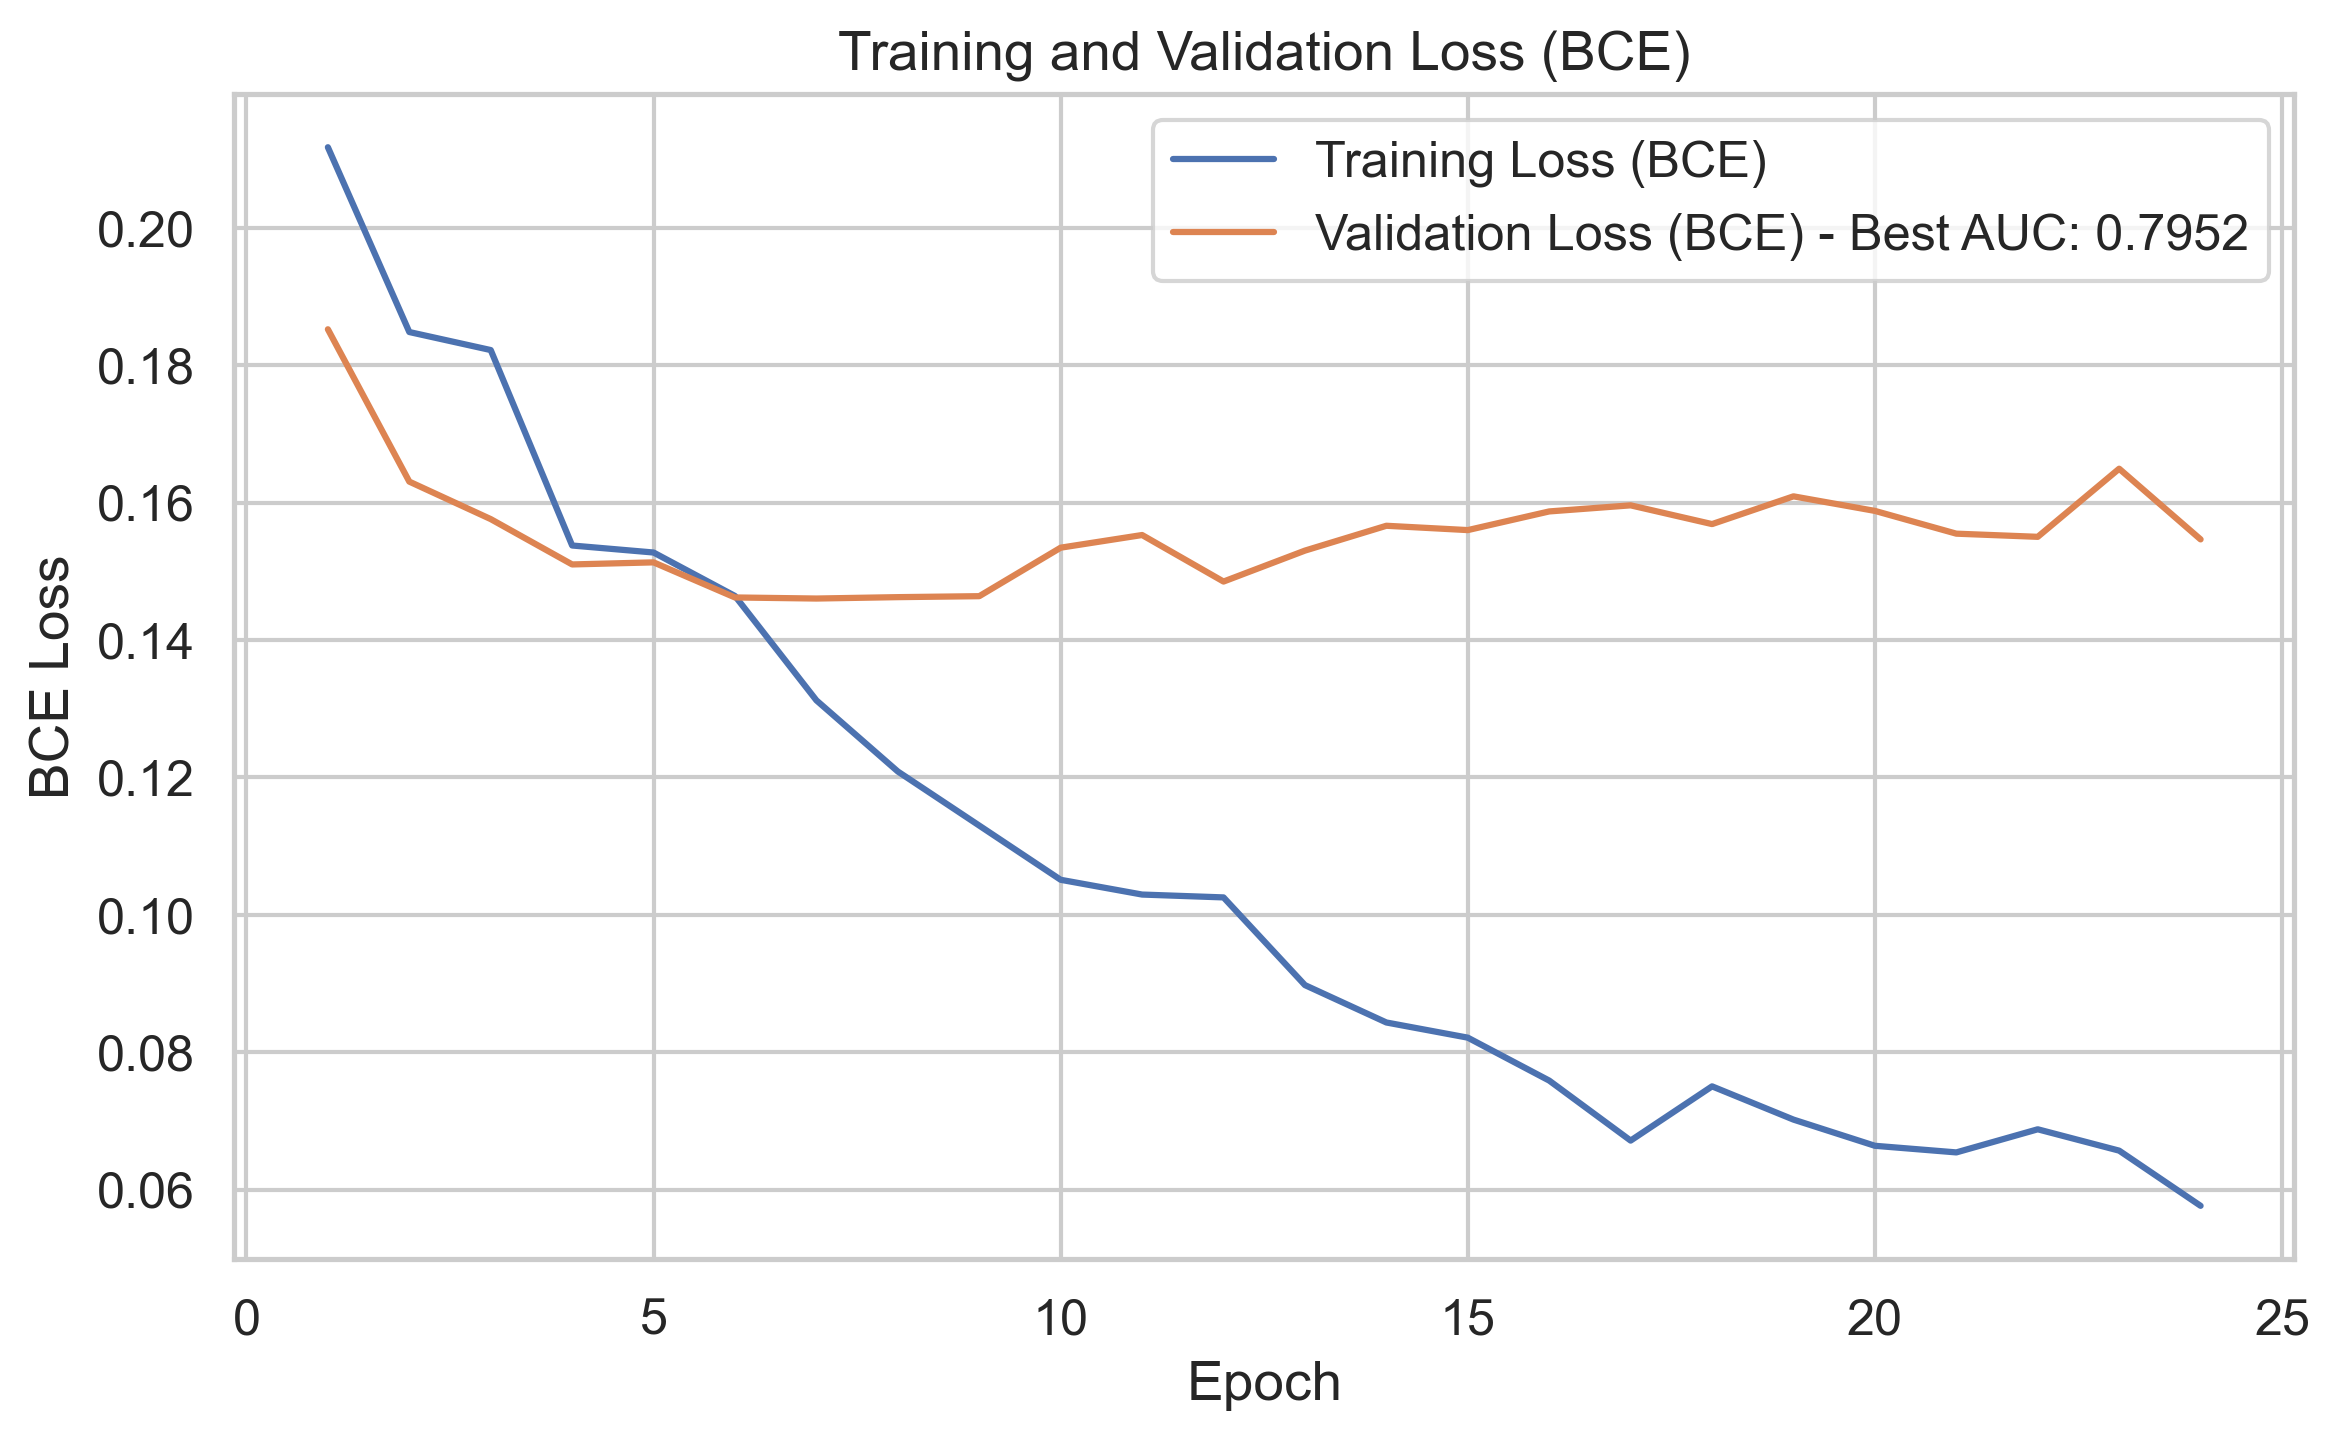

Loss plot saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\training_validation_loss_classification.png


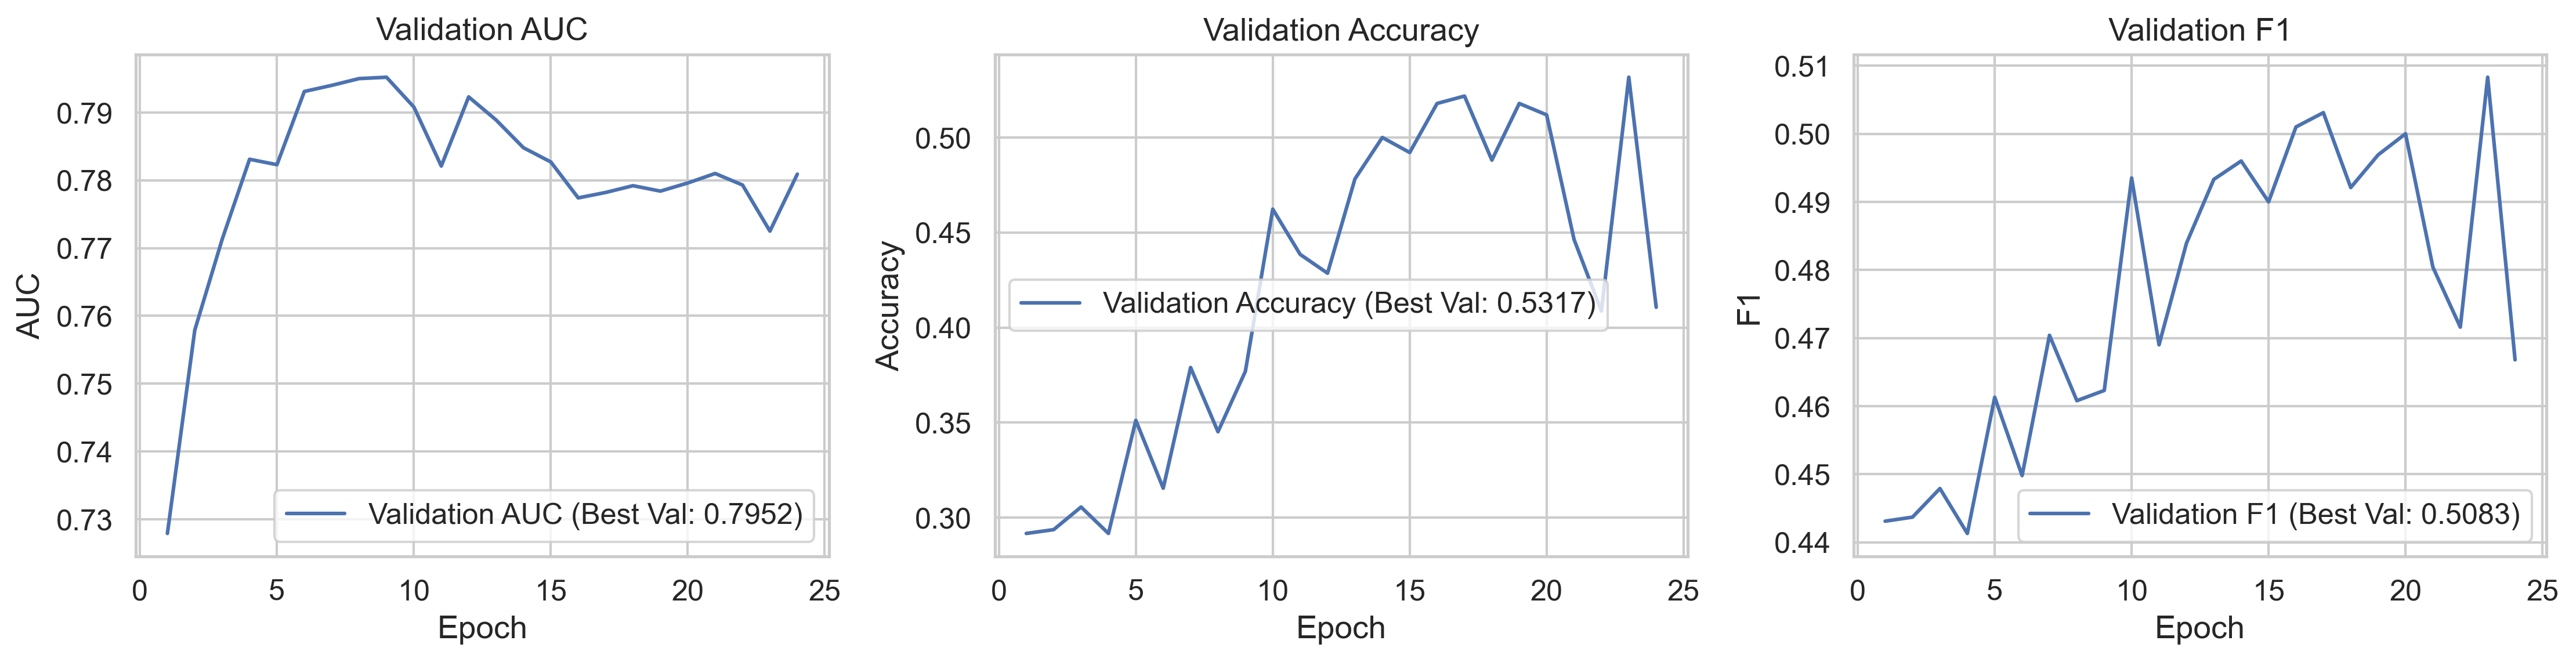

Other validation metrics plot saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\validation_metrics_history_classification.png
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.S

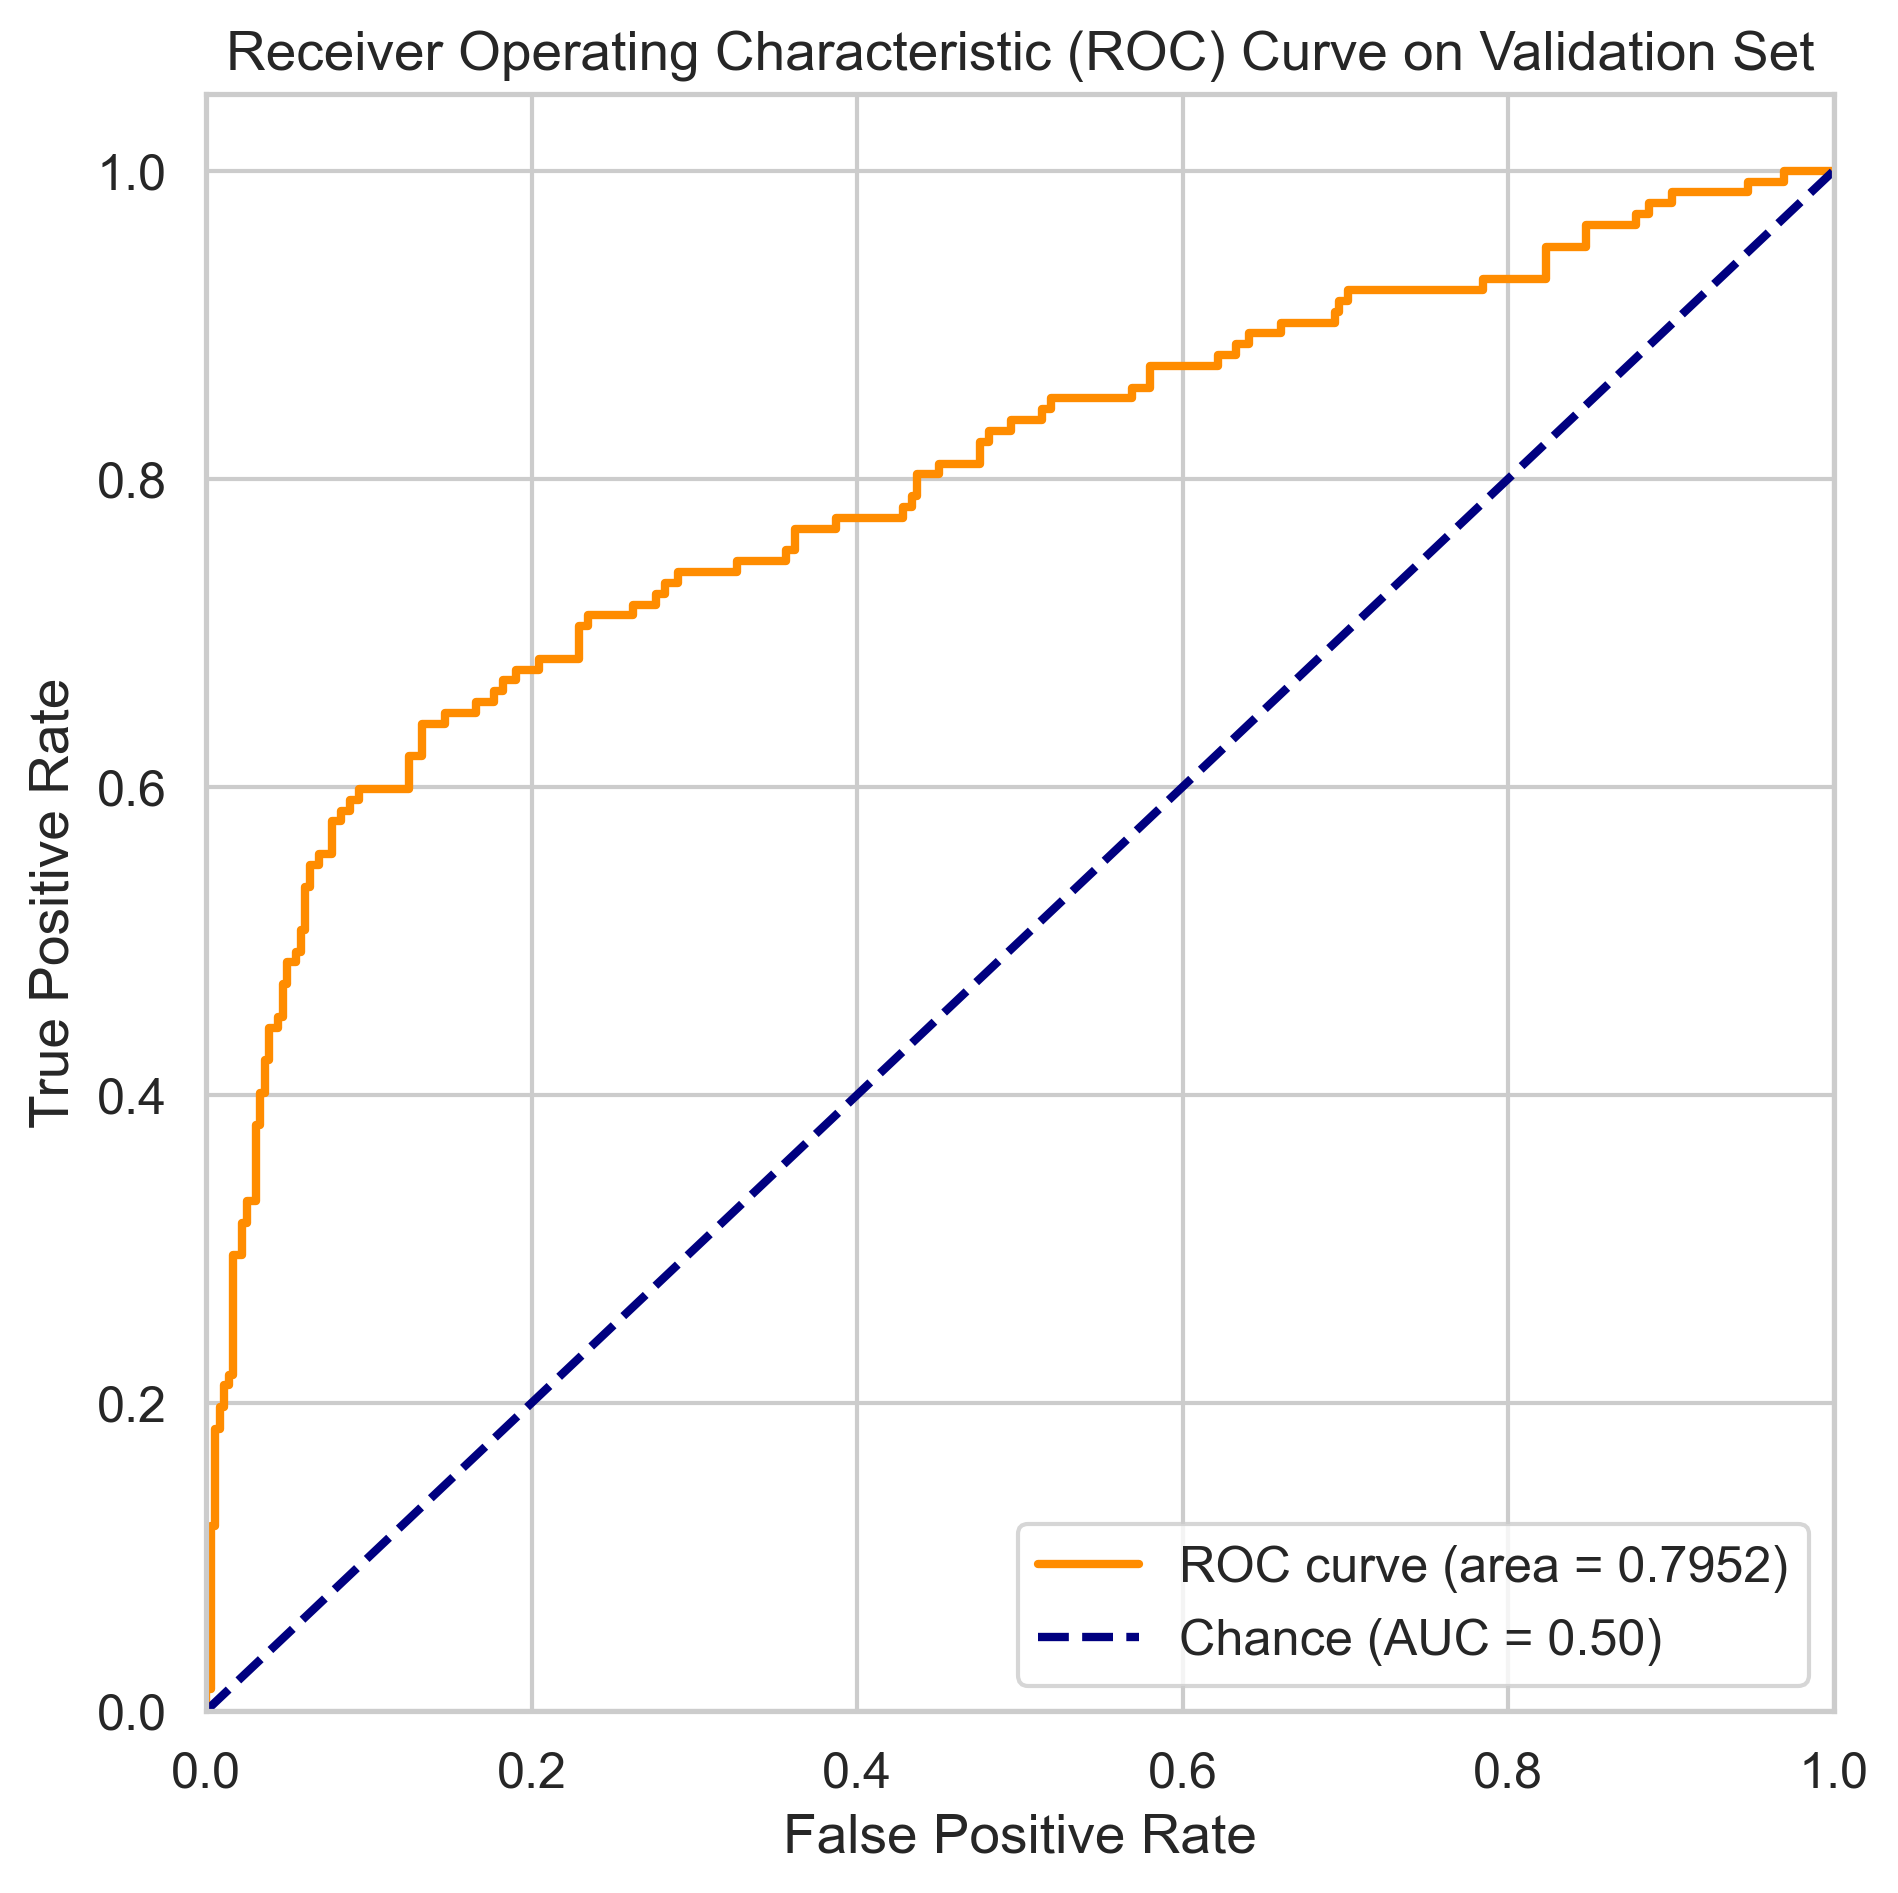

ROC curve plot (validation) saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\validation_roc_curve.png


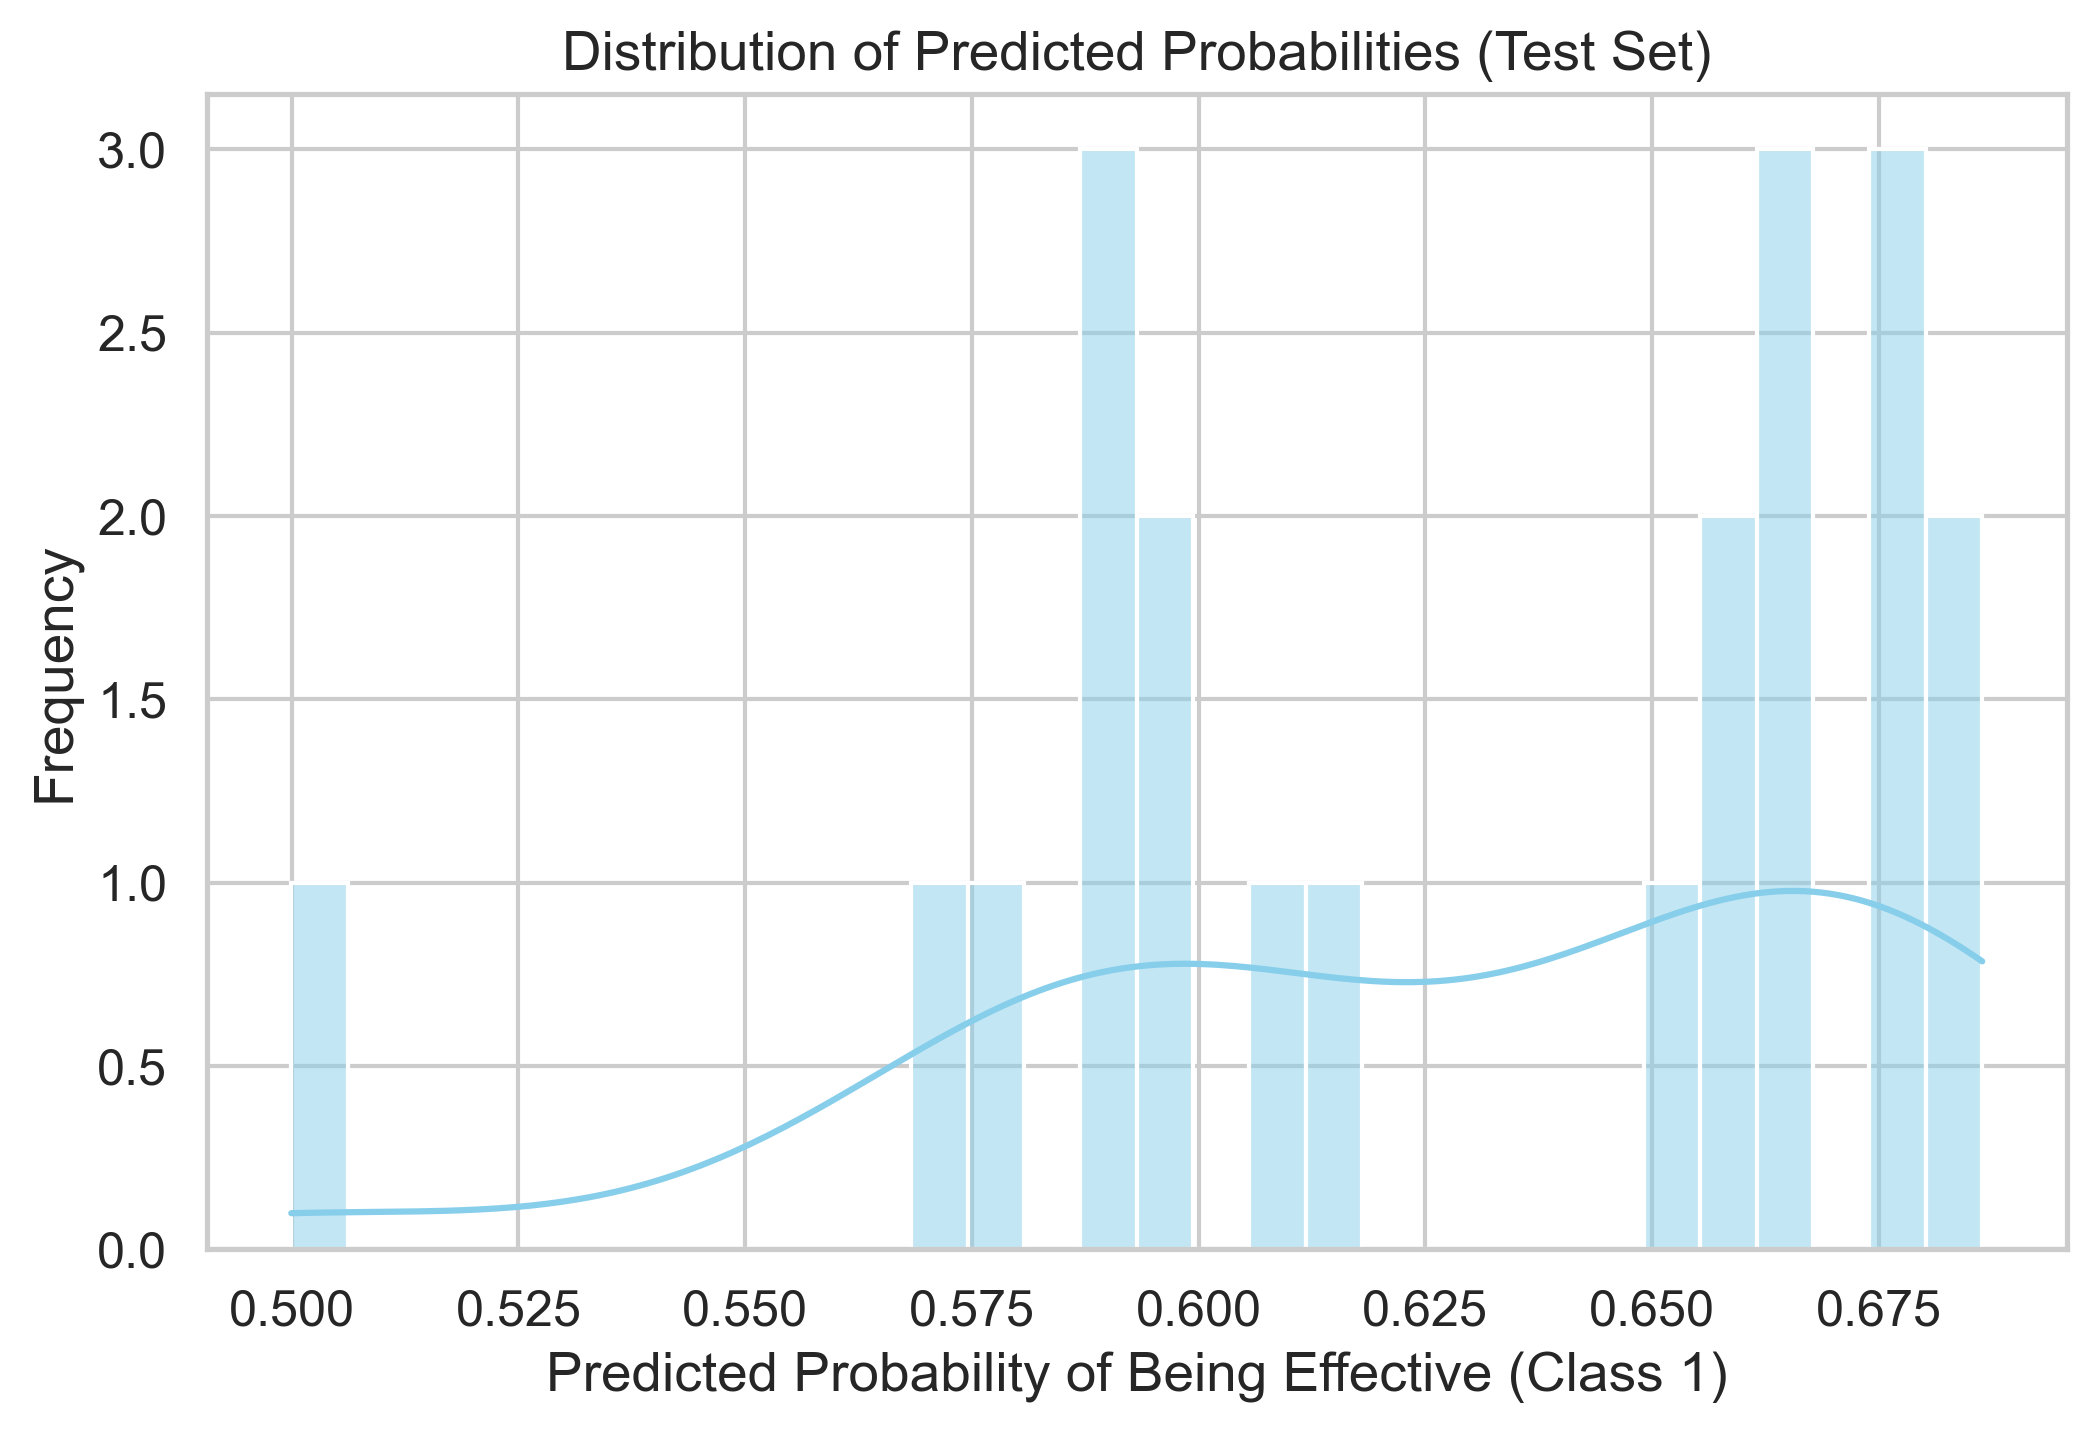

Test score distribution plot saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\test_probability_distribution.png

--- End of Notebook ---


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc # 导入ROC曲线需要的工具

history_df = pd.DataFrame(training_history)

# --- 图1: 训练和验证损失 (BCE Loss) ---
plt.figure(figsize=(8, 5))
plt.plot(history_df['epoch'], history_df['train_loss'], label='Training Loss (BCE)')
# MODIFICATION: 使用新的早停实例(early_stopper_clf)和其记录的最佳分数(best_score)
plt.plot(history_df['epoch'], history_df['val_loss'], label=f'Validation Loss (BCE) - Best AUC: {early_stopper_clf.best_score:.4f}')
plt.title('Training and Validation Loss (BCE)')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
loss_plot_path = os.path.join(CONFIG["results_dir"], "training_validation_loss_classification.png")
plt.savefig(loss_plot_path, dpi=300)
plt.show()
print(f"Loss plot saved to: {loss_plot_path}")


# --- 图2: 其他验证指标 (AUC, Accuracy, F1等) ---
# MODIFICATION: 使用新的分类指标字典 (metrics_eval_dict_clf)
num_metrics_to_plot = len(metrics_eval_dict_clf)
if num_metrics_to_plot > 0:
    plt.figure(figsize=(5 * num_metrics_to_plot, 4))
    plot_idx = 1
    for metric_name in metrics_eval_dict_clf.keys():
        metric_values = history_df[f"val_{metric_name}"]
        # 对于所有分类指标, 都是越大越好
        best_val_for_metric = metric_values.max()
        label_suffix = f' (Best Val: {best_val_for_metric:.4f})'

        plt.subplot(1, num_metrics_to_plot, plot_idx)
        plt.plot(history_df['epoch'], history_df[f"val_{metric_name}"], label=f'Validation {metric_name}{label_suffix}')
        plt.title(f'Validation {metric_name}')
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.legend(loc='best')
        plt.grid(True)
        plot_idx += 1
    plt.tight_layout()
    metrics_plot_path = os.path.join(CONFIG["results_dir"], "validation_metrics_history_classification.png")
    plt.savefig(metrics_plot_path, dpi=300)
    plt.show()
    print(f"Other validation metrics plot saved to: {metrics_plot_path}")


# --- 图3: NEW - ROC曲线 (替换原来的散点图) ---
# 获取最佳模型在验证集上的最终预测 (真实标签 和 预测概率)
_, val_true_final, val_prob_final = training_wrapper.evaluate(val_loader, has_labels=True)

# 计算ROC曲线的各个点
fpr, tpr, thresholds = roc_curve(val_true_final, val_prob_final)
# 计算AUC值 (我们也可以直接从val_scores_dict中获取)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)') # 对角线代表随机猜测
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on Validation Set')
plt.legend(loc="lower right")
plt.grid(True)
roc_plot_path = os.path.join(CONFIG["results_dir"], "validation_roc_curve.png")
plt.savefig(roc_plot_path, dpi=300)
plt.show()
print(f"ROC curve plot (validation) saved to: {roc_plot_path}")


# --- 图4: 测试集预测概率的分布 (基本不变，仅更新标签和列名) ---
plt.figure(figsize=(8, 5))
# MODIFICATION: 使用新的列名 'Predicted_Effective_Probability'
sns.histplot(results_output_df['Predicted_Effective_Probability'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Predicted Probabilities (Test Set)')
plt.xlabel('Predicted Probability of Being Effective (Class 1)')
plt.ylabel('Frequency')
plt.grid(True)
test_score_dist_path = os.path.join(CONFIG["results_dir"], "test_probability_distribution.png")
plt.savefig(test_score_dist_path, dpi=300)
plt.show()
print(f"Test score distribution plot saved to: {test_score_dist_path}")

print("\n--- End of Notebook ---")


## 11. NEW - 寻找最佳分类阈值 (Find Optimal Classification Threshold)
# 这一步使用我们已经得到的验证集结果来找到最佳的决策边界


--- Finding Optimal Threshold on Validation Set ---
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DE

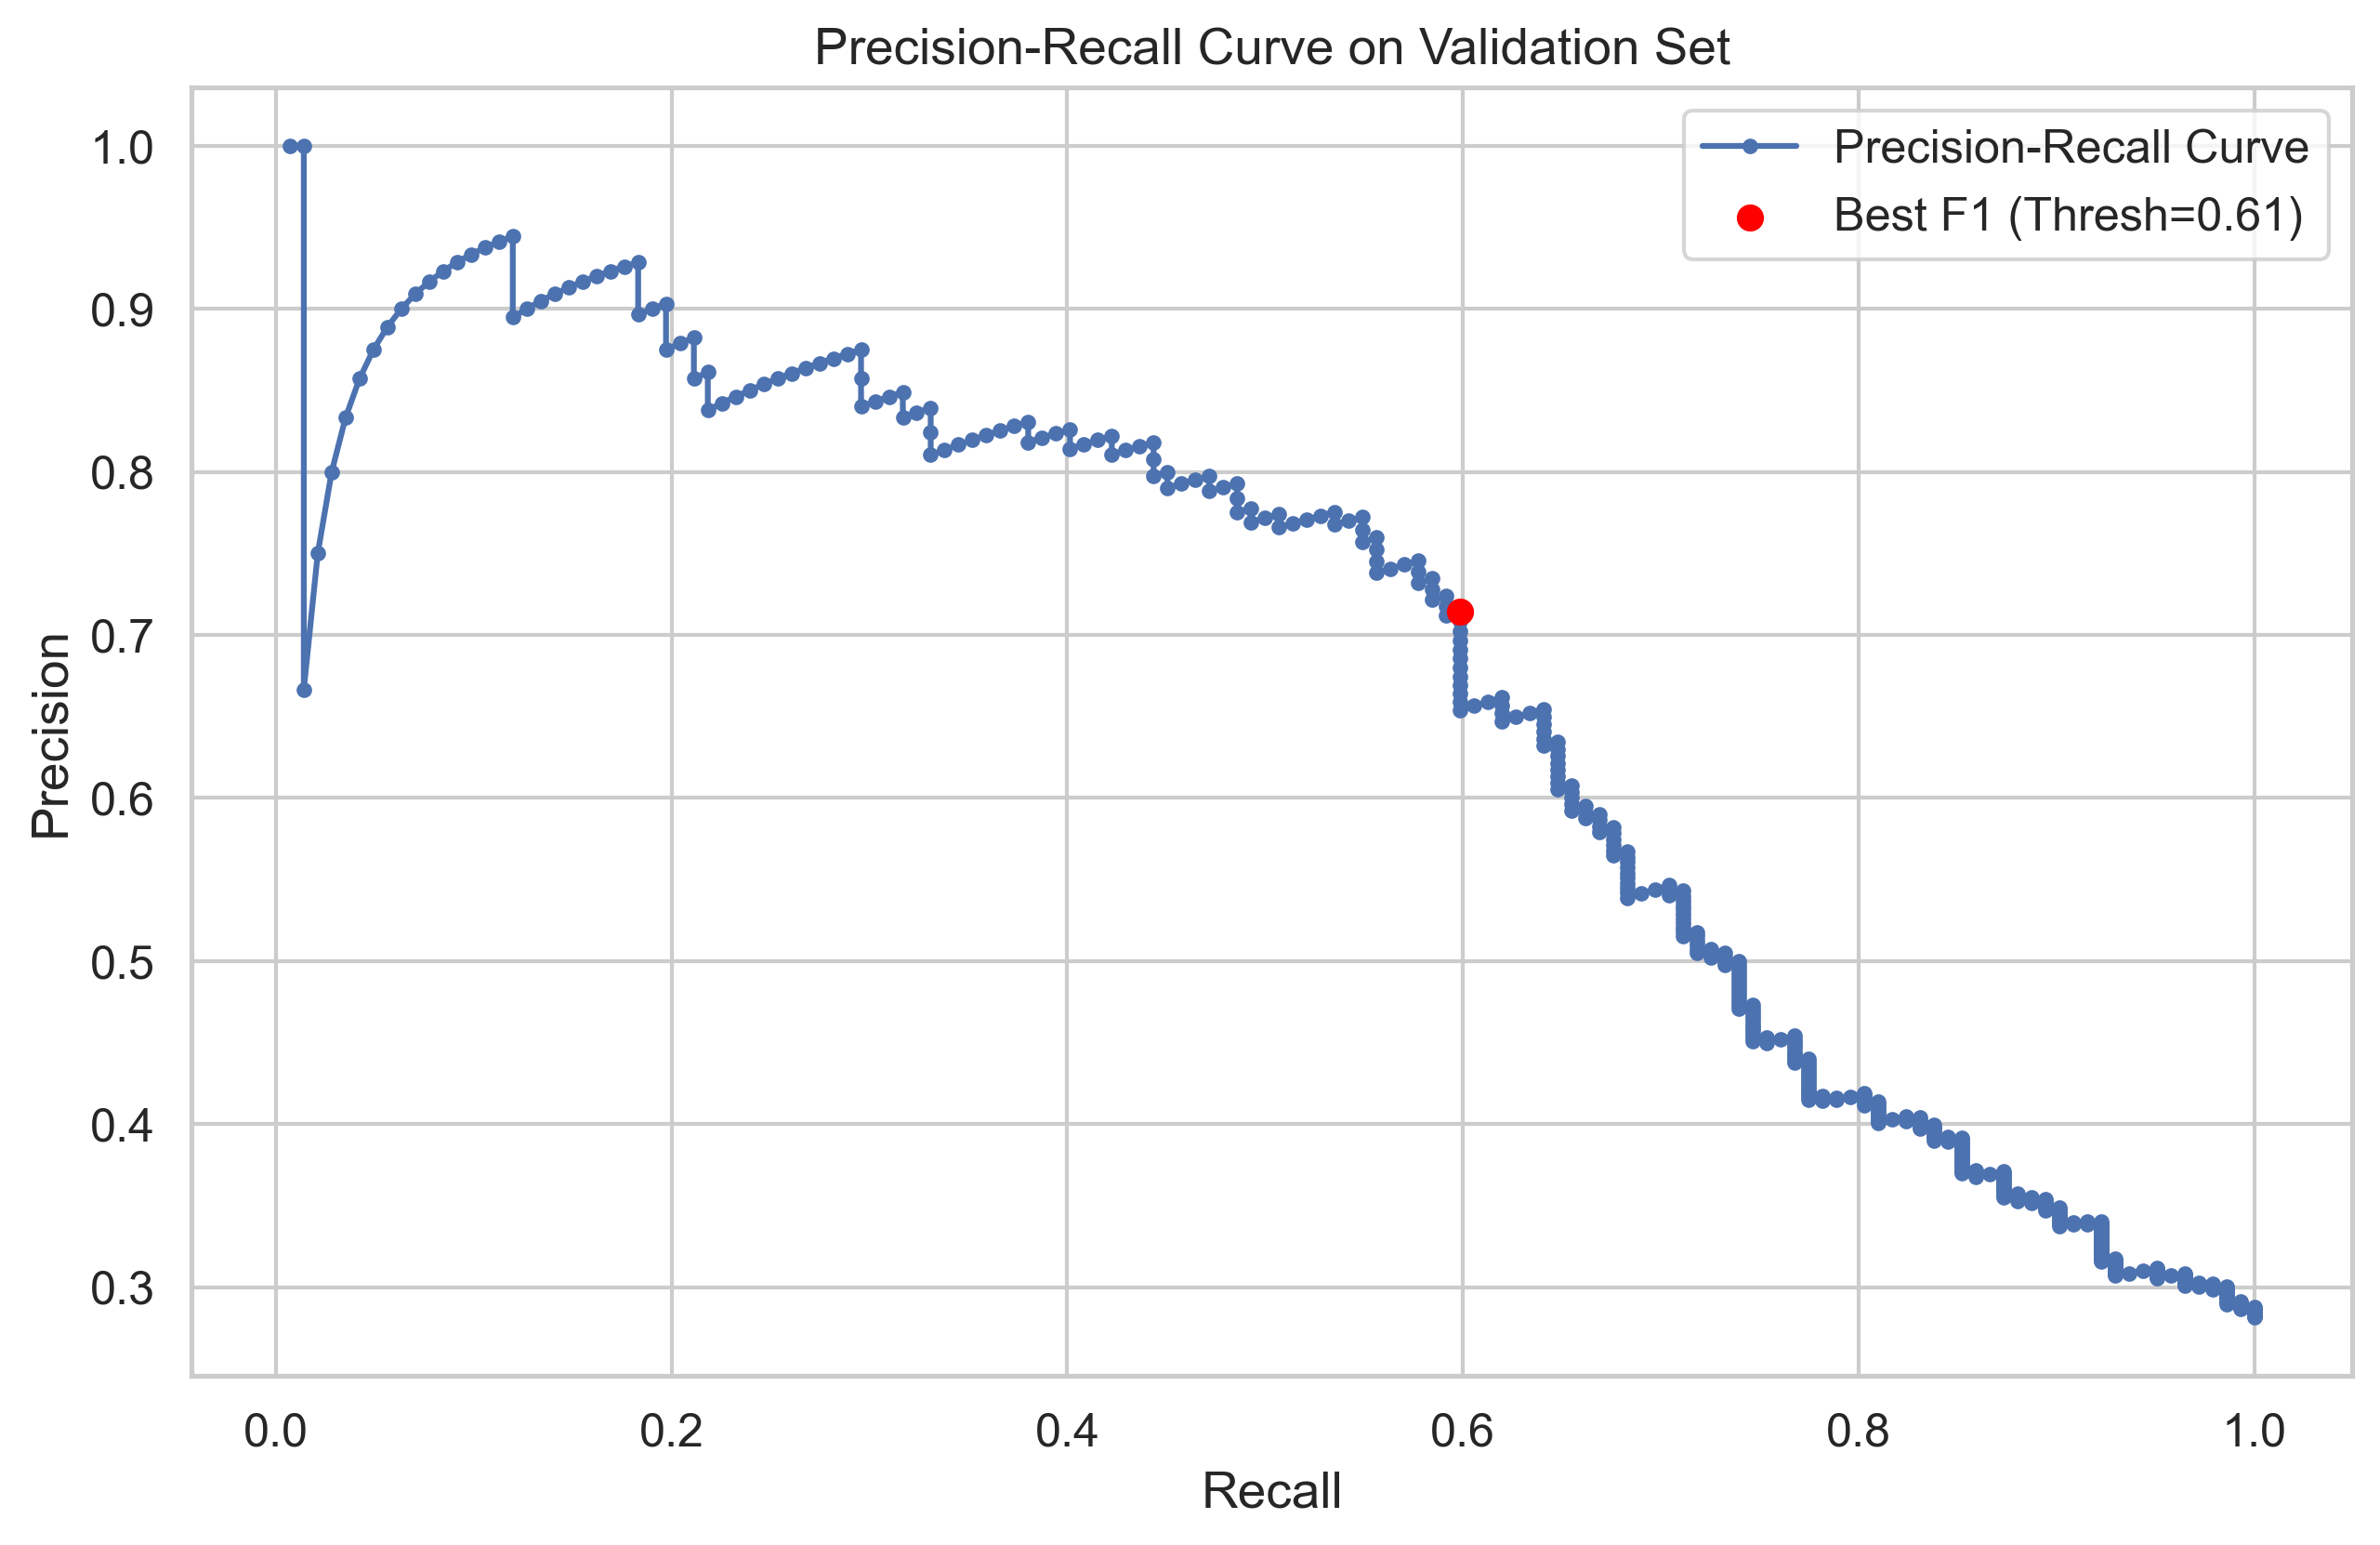


We will consider the optimal threshold for classification to be: 0.61


In [13]:
from sklearn.metrics import f1_score, precision_recall_curve
import numpy as np

print("\n--- Finding Optimal Threshold on Validation Set ---")

# 从我们之前的评估中，我们已经有了验证集的真实标签和预测概率
# _, val_true_final, val_prob_final = training_wrapper.evaluate(...)
# 如果您没有保存这些变量，可以重新运行一次evaluate来获取它们
# 为了确保我们使用的是最佳模型，重新运行一次是很好的做法
_, val_true_final, val_prob_final = training_wrapper.evaluate(val_loader, has_labels=True)

# 方法1：通过遍历寻找F1分数的最大值 (简单直观)
print("\nMethod 1: Maximizing F1-Score by iterating through thresholds...")
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(val_true_final, (val_prob_final >= t).astype(int)) for t in thresholds]

# 找到F1分数最高的那个点的索引
ix = np.argmax(f1_scores)
best_threshold_f1 = thresholds[ix]
max_f1_score = f1_scores[ix]

print(f"Best Threshold to maximize F1-Score: {best_threshold_f1:.2f}")
print(f"F1-Score at this threshold: {max_f1_score:.4f}")


# 方法2：使用精确率-召回率曲线 (更专业的方法)
# precision_recall_curve 这个函数能高效地计算出所有可能的阈值下的P和R
precisions, recalls, thresholds_pr = precision_recall_curve(val_true_final, val_prob_final)

# 计算每个阈值对应的F1分数, 注意要避免除以0的错误
# f1 = 2 * (p * r) / (p + r)
f1_scores_pr = (2 * precisions * recalls) / (precisions + recalls)
# 找到F1分数最高的那个点的索引 (忽略最后一个元素，因为它对应于一个没有预测的极端情况)
ix_pr = np.argmax(f1_scores_pr[:-1])
best_threshold_pr = thresholds_pr[ix_pr]
max_f1_score_pr = f1_scores_pr[ix_pr]

print("\nMethod 2: Using Precision-Recall curve...")
print(f"Best Threshold from P-R curve: {best_threshold_pr:.4f}")
print(f"F1-Score at this threshold: {max_f1_score_pr:.4f}")

# 可视化P-R曲线和F1分数
plt.figure(figsize=(10, 6))
plt.plot(recalls[:-1], precisions[:-1], marker='.', label='Precision-Recall Curve')
plt.scatter(recalls[ix_pr], precisions[ix_pr], marker='o', color='red', label=f'Best F1 (Thresh={best_threshold_pr:.2f})', zorder=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

# --- 最终结论 ---
# 我们可以选择一个阈值用于最终的决策
OPTIMAL_THRESHOLD = best_threshold_f1
print(f"\nWe will consider the optimal threshold for classification to be: {OPTIMAL_THRESHOLD:.2f}")

In [14]:
# 2. 使用我们找到的最佳阈值
OPTIMAL_THRESHOLD = 0.6099 # 我们之前找到的值

optimal_preds = (val_prob_final >= OPTIMAL_THRESHOLD).astype(int)
accuracy_at_optimal = accuracy_score(val_true_final, optimal_preds)
# 我们也知道此时的F1分数是0.6513
f1_at_optimal = f1_score(val_true_final, optimal_preds) # 这应该会算出接近0.6513的值

print(f"\nAccuracy at optimal threshold ({OPTIMAL_THRESHOLD}): {accuracy_at_optimal:.4f}")
print(f"F1-Score at optimal threshold ({OPTIMAL_THRESHOLD}): {f1_at_optimal:.4f}")


Accuracy at optimal threshold (0.6099): 0.8175
F1-Score at optimal threshold (0.6099): 0.6462


In [16]:
import datetime
import os

# 你的原始 notebook 文件名
notebook_file = "LifespanPredictClass.ipynb"

# 获取当前时间并格式化为字符串 (年-月-日_时-分-秒)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# 构建输出文件名 (不含 .html 后缀，nbconvert 会自动添加)
# 例如：npclassifier_2023-10-27_10-30-55
output_filename_base = f"{os.path.splitext(notebook_file)[0]}_{timestamp}"

# 构建完整的 nbconvert 命令
# --output <basename>  nbconvert 会自动添加 .html 后缀
nbconvert_command = f"jupyter nbconvert --to html --output {output_filename_base} {notebook_file}"

print(f"将要执行的命令: {nbconvert_command}")

# 在 Jupyter Notebook 代码单元格中执行
!{nbconvert_command}

print(f"\n检查输出文件: {output_filename_base}.html")


将要执行的命令: jupyter nbconvert --to html --output LifespanPredictClass_2025-06-27_01-18-46 LifespanPredictClass.ipynb

检查输出文件: LifespanPredictClass_2025-06-27_01-18-46.html


[NbConvertApp] Converting notebook LifespanPredictClass.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 1928579 bytes to LifespanPredictClass_2025-06-27_01-18-46.html
